# Environment 

In [2]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


## Imports

In [4]:
import shap

In [15]:
import sys
sys.path.append('.')
import os
from spikelearn import frankenstein, shuffle_val_predict
from spikelearn.models import shuffle_cross_predict
from spikelearn.data import io, SHORTCUTS, select, to_feature_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from spikelearn import bootstrapping as bs

# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
# from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
pearson = lambda t, p: pearsonr(t, p)[0]

from sklearn.model_selection import GroupShuffleSplit

from spikelearn.data.selection import select, to_feature_array, frankenstein
from spikelearn.data import io, SHORTCUTS
from spikelearn.models import shuffle_val_predict
from sklearn.metrics import make_scorer, cohen_kappa_score

from scipy.stats import ttest_rel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [16]:
from scipy.stats import ttest_ind

In [17]:
from itertools import product
from spikelearn.models.shuffle_decoding import MonteCarloFeatures

from spikelearn.measures.univariate import bracketing

In [18]:
from sklearn.linear_model import BayesianRidge

In [19]:
from sklearn.metrics import accuracy_score

## Functions

In [7]:
@make_scorer
def cont_accuracy(y_true, y_pred):
    return accuracy_score(y_true, np.round(y_pred/100).astype(int)*100)

In [8]:
scoring={'Explained variance':'explained_variance', "Pearson's r":make_scorer(pearson), 'Accuracy':cont_accuracy}

def cross_val(df, clf, n_splits=100):
    res = cross_validate(clf, df.values, df.reset_index().time, df.reset_index().trial, 
                         cv = GroupShuffleSplit(n_splits), scoring=scoring, return_train_score=False)

    res = pd.DataFrame(res).filter(regex='test').melt()
    res.variable = res.variable.apply(lambda s: s[5:])
    return res

### Behavior


In [25]:
from scipy.optimize import curve_fit
from sklearn.metrics import explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def dprime(pred):
    TP = pred.astype(int).sum()/len(pred)
    FP = (pred==False).astype(int).sum()/len(pred)
    return (norm.ppf(TP) - norm.ppf(FP))

def degrau(x, baixo, alto, th):
    return baixo*((x<th).astype(int)) + alto*((x>=th).astype(int))

def best_degrau(x, y):
    ths = x[2:-2]
    scores = np.array([((y - degrau(x, y[x<th].mean(), y[x>=th].mean(), th))**2).sum() for th in ths])
    th = ths[scores.argmin()]
    return y[x<th].mean(), y[x>=th].mean(), th
        
def compare_linear_vs_step(x,y, plot=True, return_raw = False):
    a, b = np.polyfit(x,y,1)
    linear_pred = a*x + b
    r_lin = explained_variance_score(y, linear_pred)

    #pars, _ = curve_fit(degrau, x, y, p0=[-.2,1,100], method='trf')
    step_pred = degrau(x, *best_degrau(x, y))
    r_step = explained_variance_score(y, step_pred)

    if plot:
        plt.plot(x,y, label='D prime')
        plt.plot(x, linear_pred, label= 'Regression, R^2: {:.2f}'.format(r_lin), linewidth=2)
        plt.plot(x, step_pred, label='Step, R^2: {:.2f}'.format(r_step), linewidth=2)
        plt.legend(loc='upper right')
    if return_raw:
        return linear_pred, step_pred
    else:
        return r_lin, r_step

# Animals learn fast

## They disengage in long sessions 

In [26]:
bhv = {}
for label in SHORTCUTS['groups']['eletro']:
    bhv[label] = select(io.load(label, 'behav_stats')).reset_index()
    bhv[label]['rat'] = int(label.split()[-1][0]) if '_2' in label else int(label.split()[-1])
    bhv[label]['day'] = 2 if '_2' in label else 1
    bhv[label]['label'] = label
    bhv[label]['percent_trial'] = bhv[label].trial/bhv[label].trial.max()*100
allr = pd.concat(bhv.values())

/disk1/home/svo6059/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [27]:
sns.set_palette('deep', color_codes=True)

/disk1/home/svo6059/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


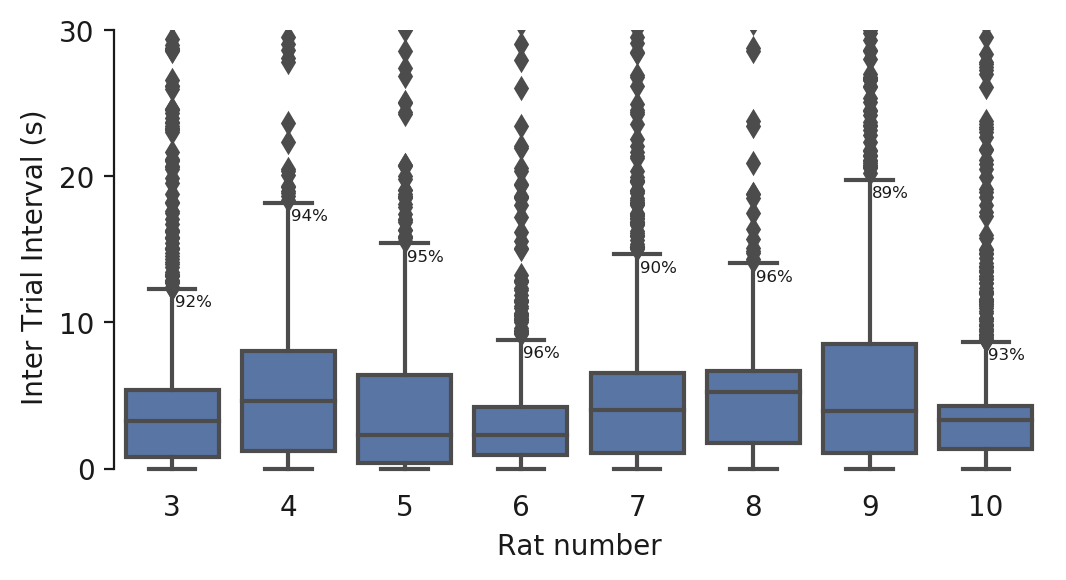

In [28]:
plt.figure(figsize=(6,3), dpi=200)
ax = sns.boxplot(y='intertrial_interval', x='rat', data = pd.concat(bhv.values()), color='b')
plt.ylim(-1,30)
plt.ylabel('Inter Trial Interval (s)')
plt.xlabel('Rat number')
for rat in range(3,11):
    rdf = allr[allr.rat==rat]
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    inside = (rdf.intertrial_interval < (Q3 + 1.5*IQR))
    ax.text(rat-3+.02, rdf[inside].intertrial_interval.max() - 1.2, 
            '{:.0%}'.format(inside.mean()), fontsize=6)
plt.yticks([0, 10, 20, 30])
ax.tick_params(axis='x', length=0)
ax.spines['left'].set_bounds(0,30)
sns.despine(bottom=True)

In [29]:
import matplotlib.gridspec as gridspec

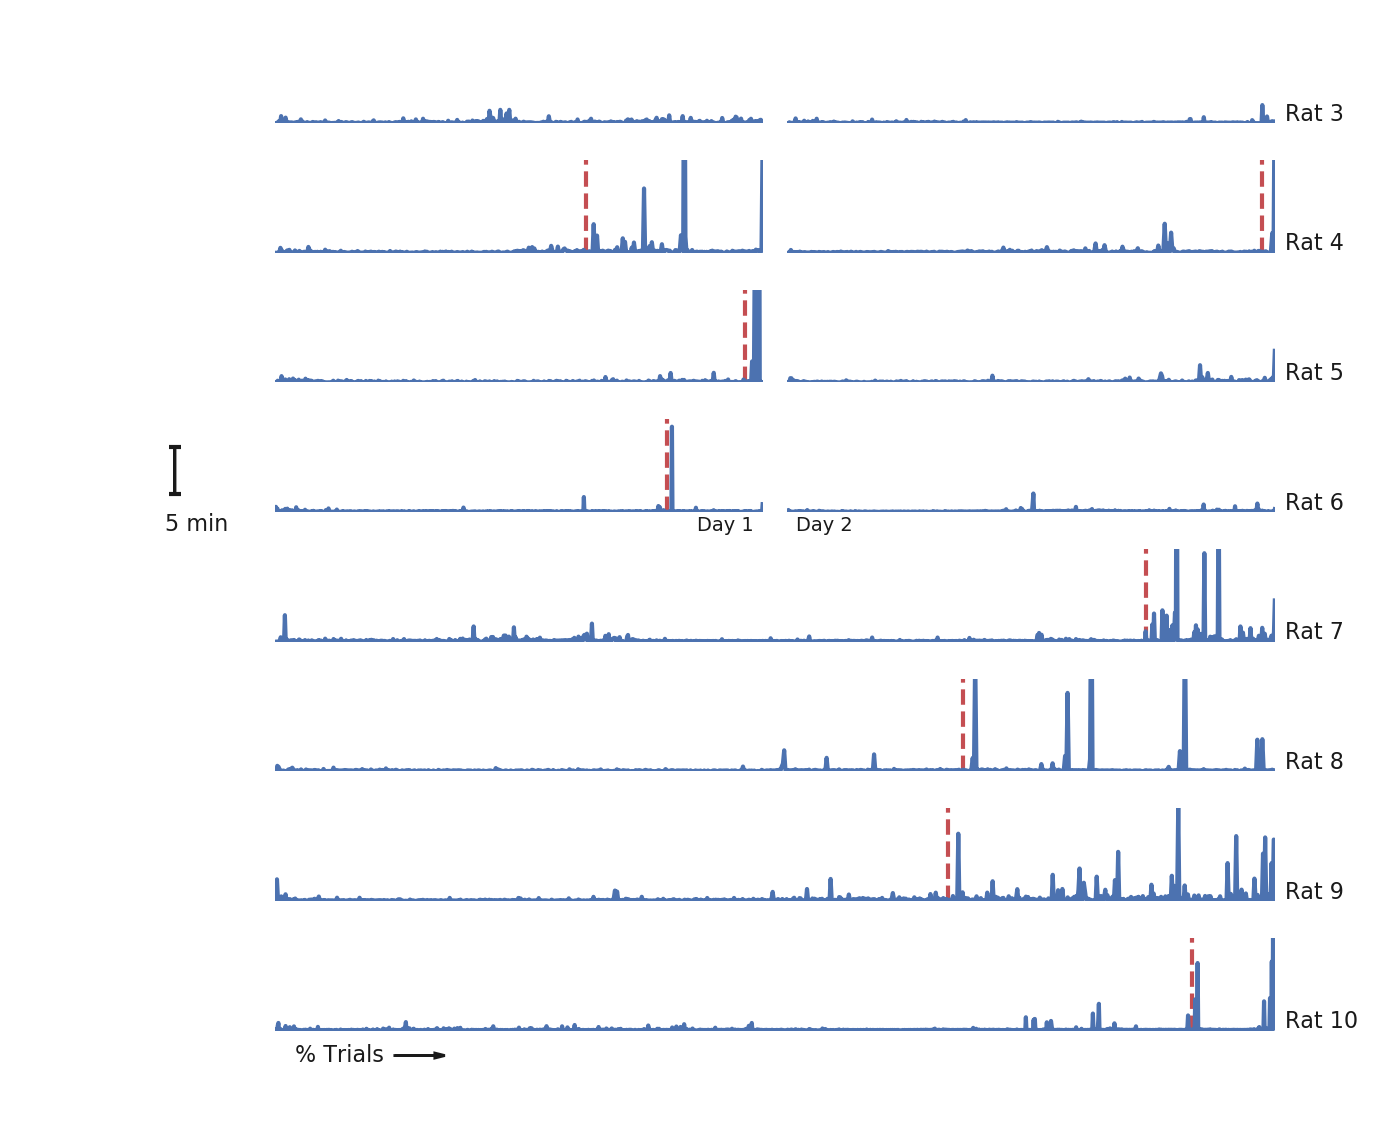

In [30]:
fig = plt.figure(figsize=(10,5), constrained_layout=False, dpi=200)
gs1 = gridspec.GridSpec(nrows=8, ncols=2, figure= fig, left=0, right=0.5, 
                        wspace=0.05, hspace=0.4, bottom=0,top=1)
shape = (8,2)
axes = {}
for label in allr.label.unique():
    rdf = allr[allr.label==label]
    day = rdf.day.values[0]
    rat = rdf.rat.values[0]
    if rat < 7:
        axes[label] = fig.add_subplot(gs1[rat-3, day-1])
    else:
        axes[label] = fig.add_subplot(gs1[rat-3, :])
    ax = axes[label]
    iti = rdf.set_index('percent_trial').intertrial_interval/10
#     plt.subplot2grid(shape, (rat-3, day-1), 1, 1 if rat < 7 else 2)
    ax.plot(rdf.percent_trial, rdf.intertrial_interval/60)
#     iti.rolling(5, center=False).mean().plot()
    
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    b = (rdf.intertrial_interval.rolling(5).mean() > 60) #(Q3 + 1.5*IQR)
    ax.vlines(rdf[b.shift(-10).fillna(False)].percent_trial.min(), 0, 100, color='r', linestyles='--', linewidth=1.5)
    if rat > 2:
        ax.set_axis_off()
#     sns.despine(bottom=True, left=True, trim=True)
    ax.set_ylim([0,10])
    ax.set_xlim([0,100])
    if day==2 or rat > 6:
        if rat <7:
            ax.text(102,.3, 'Rat {}'.format(rat), horizontalalignment='left', fontsize=8)
        else:
            ax.text(101,.3, 'Rat {}'.format(rat), horizontalalignment='left', fontsize=8)
            
height = ax.get_position().height
# plt.arrow()
ax = fig.add_axes([-.1,.5, .1, height])
ax.set_ylim(0,10)
ax.arrow(.5, 4, 0, 5)
ax.hlines([4,9], .47, .53)
ax.set_xlim(0,1)
ax.text(.45,0, '5 min', fontsize=8)
ax.set_axis_off()
axes['DRRD 7'].text(45, 12, 'Day 1', fontsize=7, horizontalalignment='center')
axes['DRRD 7'].text(55, 12, 'Day 2', fontsize=7, horizontalalignment='center')


ax = fig.add_axes([.01,-.05, .1, .05])
ax.text(0, .5, '% Trials', fontsize=8, verticalalignment='center')
ax.arrow(.5,.5, .2,0, head_width=.1, color='k', head_length=.05)
ax.set_axis_off()
# fig.subplots_adjust(left=0, right=1, hspace=-2, wspace=0)

In [31]:
maxtrial = {}
for label in allr.label.unique():
    rdf = allr[allr.label==label]
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    b = (rdf.intertrial_interval.rolling(5).mean() > 60) #(Q3 + 1.5*IQR)\
    maxtrial_rat = rdf[b.fillna(False)].trial.min()
    if maxtrial_rat is np.nan:
        maxtrial[label] = rdf.trial.max()+1
    else:
        maxtrial[label] = maxtrial_rat
print(maxtrial)


{'DRRD 7': 1049, 'DRRD 8': 561, 'DRRD 9': 637, 'DRRD 10': 1542, 'ELI 3': 544, 'ELI 4': 288, 'ELI 5': 501, 'ELI 6': 762, 'ELI 3_2': 626, 'ELI 4_2': 381, 'ELI 5_2': 438, 'ELI 6_2': 700}


## One session is enough 

In [32]:
pal = ['r','b']

### Group 1

In [33]:
def fill_density_above(dplot, abovey=1.5, **kwargs):
    line = dplot.get_lines()[-1]
    x,y = line.get_data()
    mask = y > abovey
    x, y = x[mask], y[mask]
    dplot.fill_between(x, 1.5*np.ones(len(y)), y,  **kwargs)

AttributeError: module 'seaborn' has no attribute 'scatterplot'

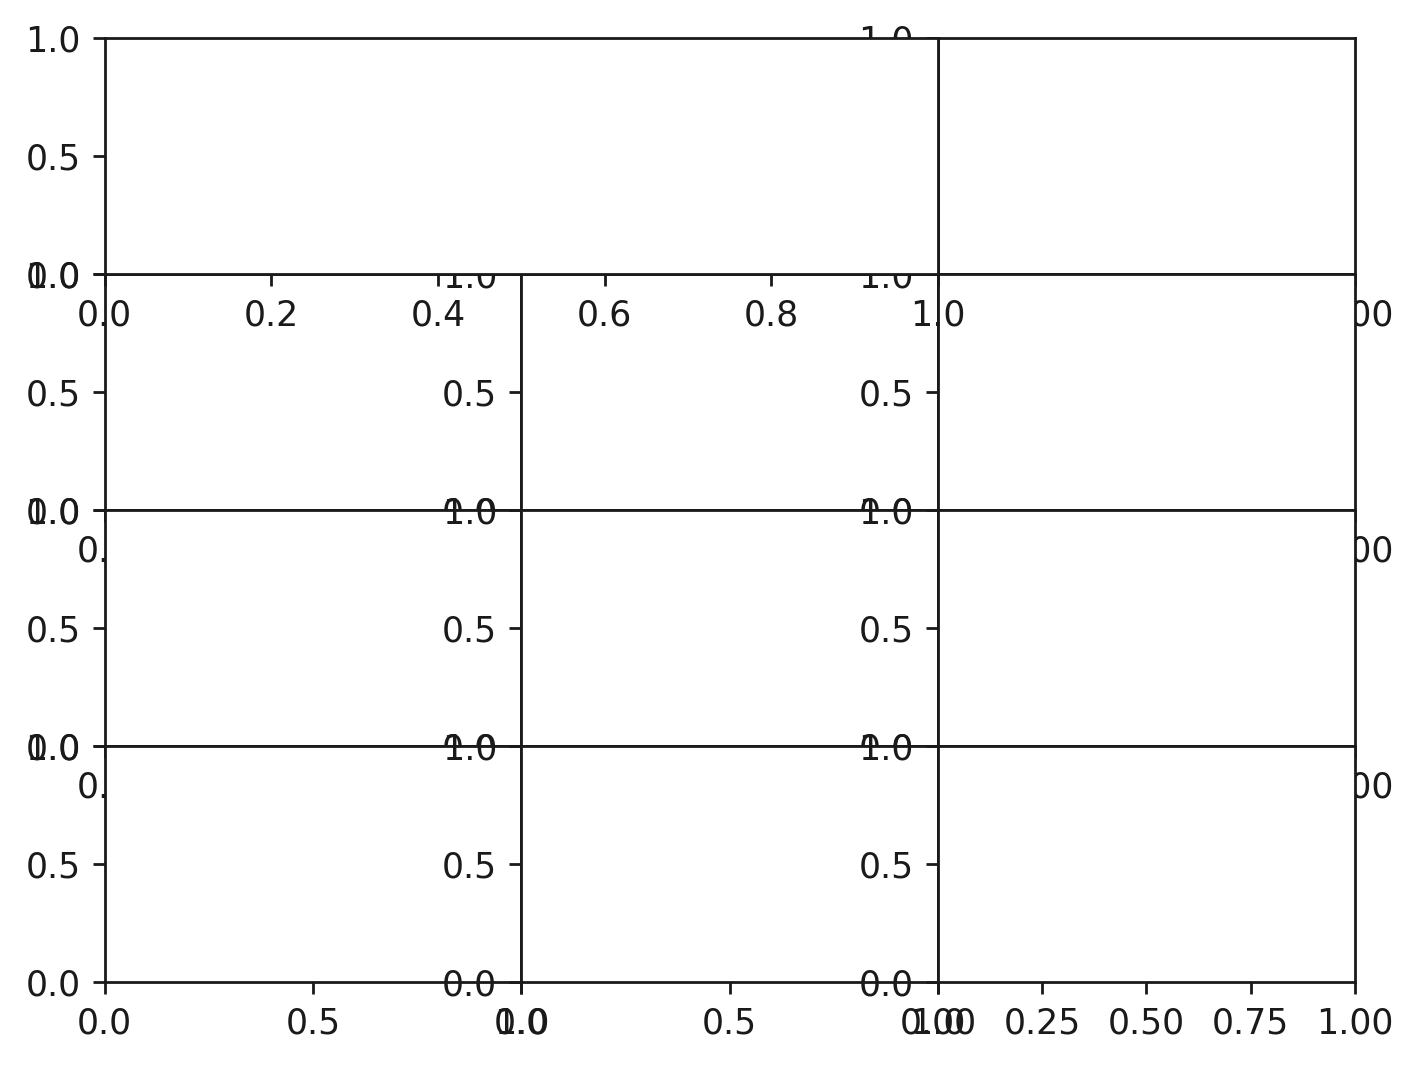

In [34]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[:4]):
    dur = select(io.load(label, 'behav_stats')).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
    dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','^'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur.set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')
    lab = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*lab) if l in dur.rewarded.unique()][::-1]))
    axs.legend(*good_labels, title='', frameon=True)
    axs.hlines(0, 0, 50, colors=pal[0], linewidth=2)
    axs.hlines(0, 50, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    g = sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'First half')
    fill_density_above(g, 1.5, color=pal[0], alpha=.3)
    
    h = sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Second half')
    fill_density_above(h, 1.5, color=pal[1], alpha=.3)
#     axd.hlines(1.5, 0, .7, linestyles='--', linewidth=.5)
    
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*lab) if l in ['Moving average']]))
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*lab) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        

    axs.text(-5.8, 3.5, 'Rat %d'%(i+7), weight = 'bold')
    
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, 50, 100])
axs.set_xticklabels(['Beginning', '50%', 'End of session\nor of engagement']);
# plt.tight_layout()


#### Hypothesis testing 

In [ ]:
from scipy.stats import f_oneway

In [ ]:
fh = []
sh = []
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[:4]):
    dur = select(io.load(label, 'behav_stats')).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['rewarded'] = dur.duration>1.5
    dur['first_half'] = dur.trial < dur.trial.median()
#     print(label)
#     print( f_oneway(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
#     print( ttest_ind(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
    
    fh.append(dur[dur.first_half].rewarded.mean())
    sh.append(dur[dur.first_half==False].rewarded.mean())
    
ttest_rel(sh, fh)

### Group 2

AttributeError: module 'seaborn' has no attribute 'scatterplot'

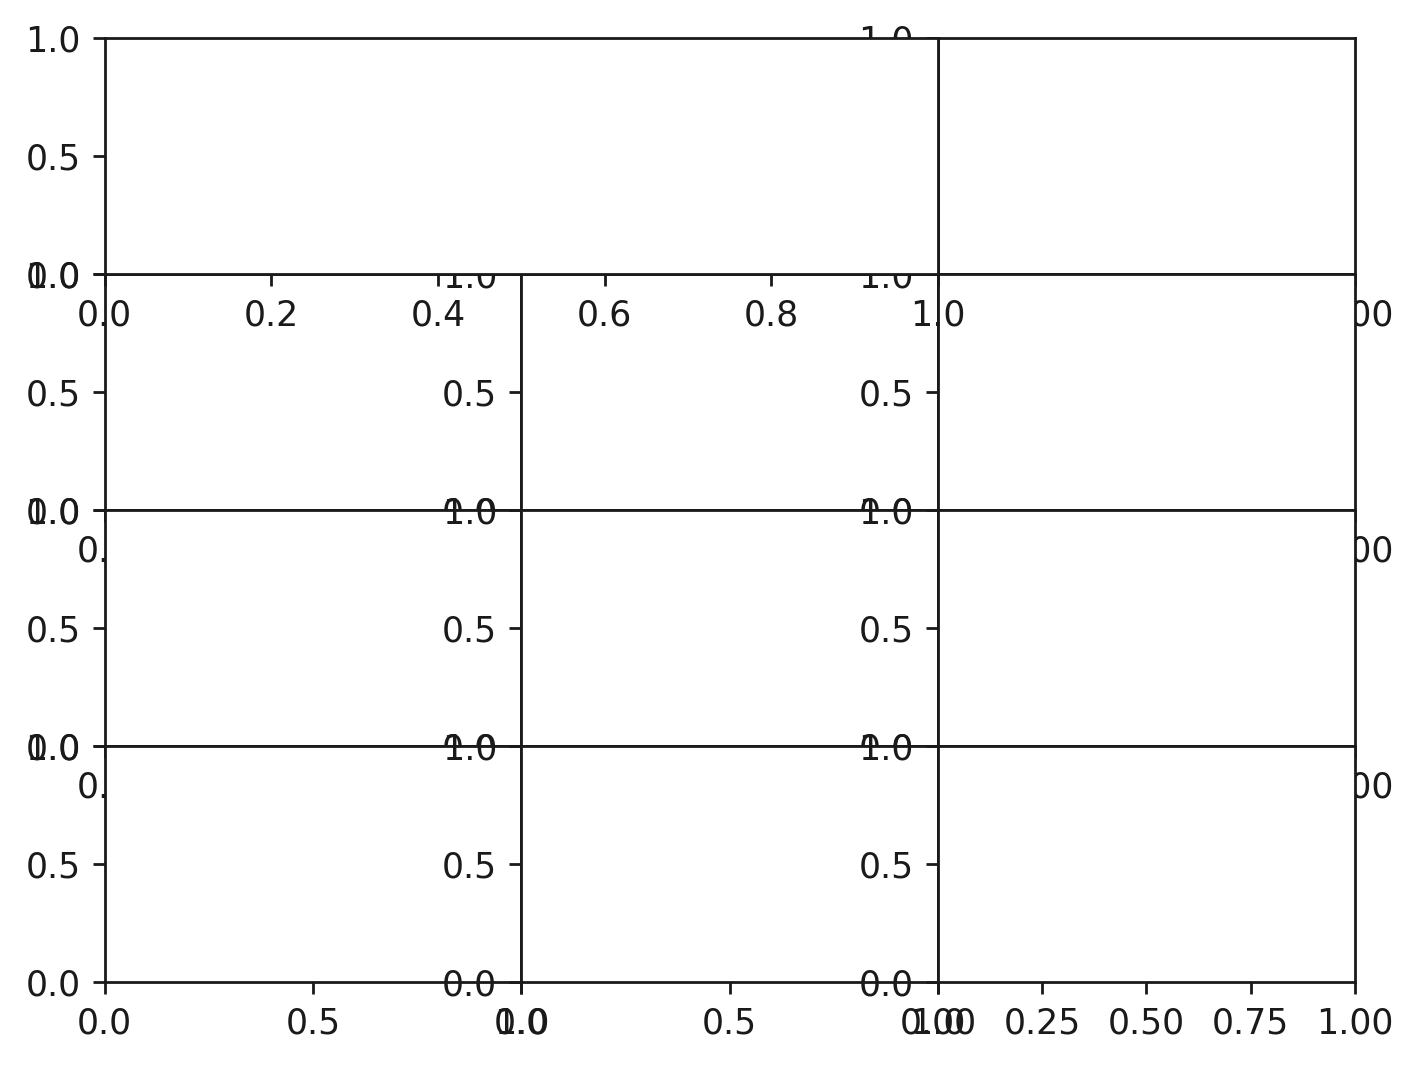

In [35]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[4:8]):
#     fig, ax = plt.subplots(figsize=(4,4))

    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['first_half'] = True
    dur2 = select(io.load(label+'_2', 'behav_stats'), is_tired=False).reset_index()
    dur2 = select(dur2, _max_trial=maxtrial[label+'_2'])
    dur2['trial'] = dur2.trial + dur.trial.max()
    dur2['first_half'] = False
    dur = dur.append(dur2)
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
#     dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','^'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur[dur.first_half].set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1)
    dur[dur.first_half==False].set_index('percent_trial').duration.rolling(50, center=True)\
                              .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')

    x = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
    
    
    final_first_sess = dur[dur.first_half].percent_trial.max()
    axs.hlines(0, 0, final_first_sess, colors=pal[0], linewidth=2)
    axs.hlines(0, final_first_sess, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    g = sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'First half')
    fill_density_above(g, 1.5, color=pal[0], alpha=.3)
    
    h = sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Second half')
    fill_density_above(h, 1.5, color=pal[1], alpha=.3)
#     axd.hlines(1.5, 0, .7, linestyles='--', linewidth=.5)
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in ['Moving average']]))
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        
    axs.text(-5.8, 3.5, 'Rat %d'%(i+3), weight = 'bold')

        
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, final_first_sess, 100])
axs.set_xticklabels(['Beginning', 'Change of session', 'End of day 2']);
# plt.tight_layout()


#### Hypothesis testing 

In [36]:
fh = []
sh = []
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[4:8]):
    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['first_half'] = True
    dur2 = select(io.load(label+'_2', 'behav_stats'), is_tired=False).reset_index()
    dur2 = select(dur2, _max_trial=maxtrial[label+'_2'])
    dur2['trial'] = dur2.trial + dur.trial.max()
    dur2['first_half'] = False
    dur = dur.append(dur2)
    dur['rewarded'] = dur.duration>1.5
#     print(label)
#     print( f_oneway(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
#     print( ttest_ind(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
    
    fh.append(dur[dur.first_half].rewarded.mean())
    sh.append(dur[dur.first_half==False].rewarded.mean())
    
ttest_rel(sh, fh)

Ttest_relResult(statistic=20.7558782599815, pvalue=0.0002445851668064605)

### Some exploration 

In [37]:
fh_period = dur[dur.first_half].offset.max() - dur[dur.first_half].onset.min()
sh_period = dur[dur.first_half==False].offset.max() - dur[dur.first_half==False].onset.min()

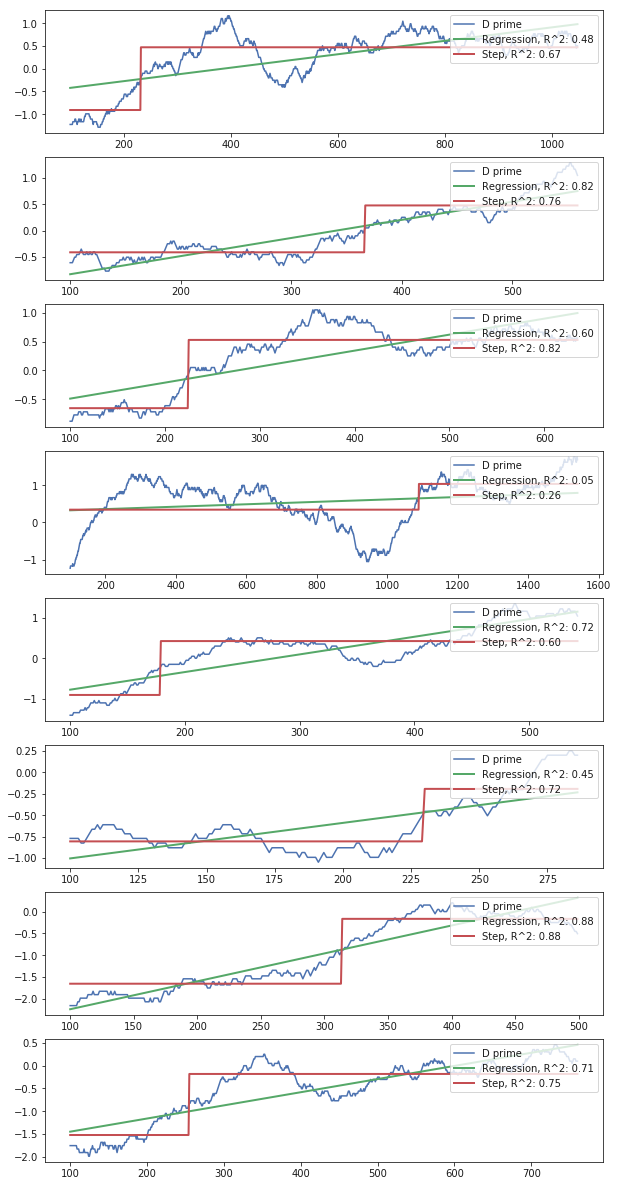

In [38]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = ( b.duration > 1.5 )

    y = b.rewarded.rolling(window).apply(dprime, raw=True)[window:]
    x = b.index[window:]

    
    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

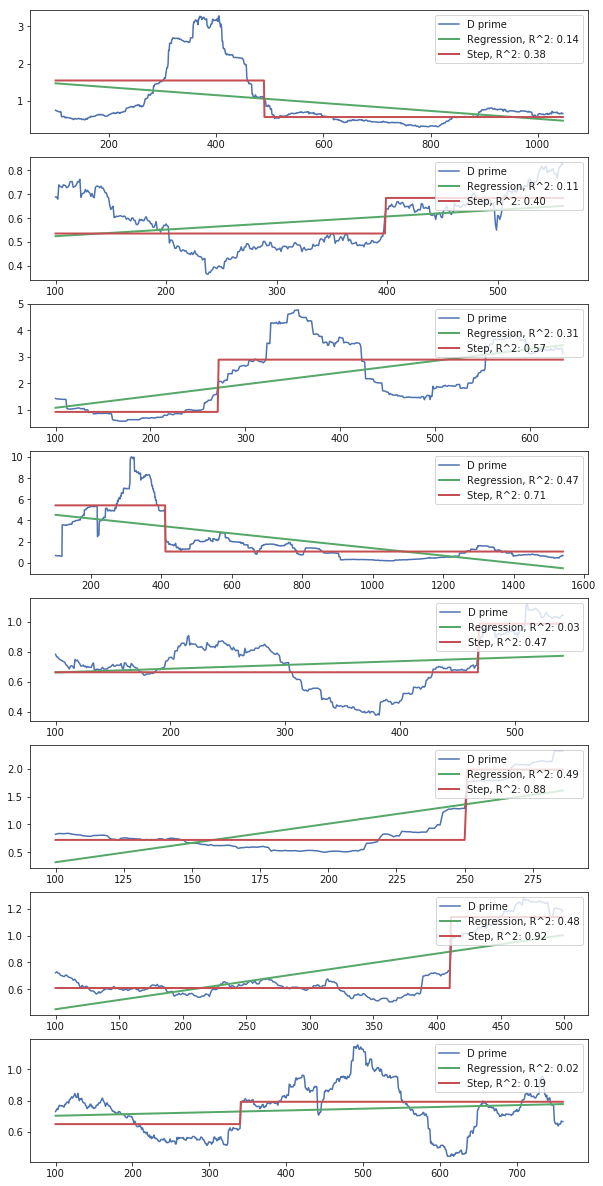

In [39]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = (b.duration>1.5)

    y = b.duration.rolling(window).apply(lambda dur: ((dur-1.5)**2).mean(), raw=True)[window:]
    x = b.index[window:]

    
    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

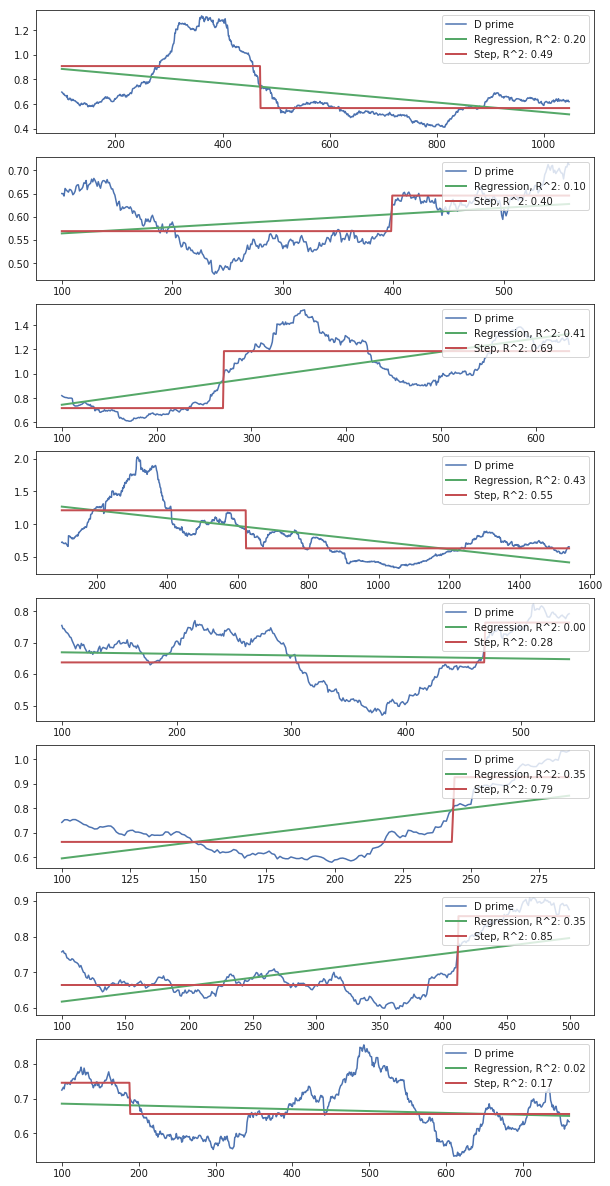

In [40]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = (b.duration>1.5)

    y = b.duration.rolling(window).apply(lambda dur: np.sqrt(((dur-1.5)**2)).mean(), raw=True)[window:]
    x = b.index[window:]

    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

# Motor activity 

In [41]:
labels = SHORTCUTS['groups']['DRRD']
dfs = [select(io.load(label, 'no_smoothing_viz'), _min_duration=1., is_selected=True, is_tired=False) for label in labels]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
for i in range(4):
    mean_activity = dfs[i].full.unstack(1).apply(lambda col: np.vstack(col.apply(lambda a: a[:150])).mean(axis=0))
    mean_activity = mean_activity/mean_activity.mean()
    mean_activity.rolling(10).mean().plot(ax = ax[i], legend=False)
    plt.sca(ax[i])
    locs, labels = plt.xticks()           # Get locations and labels
    plt.xticks(locs, locs*10 - 500)  # Set locations and labels
    plt.xlim(0,150)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
for i in range(4):
    mean_activity = dfs[i].full.unstack(1).apply(lambda col: np.vstack(col.apply(lambda a: a[-150:])).mean(axis=0))
    mean_activity = mean_activity/mean_activity.mean()
    mean_activity.rolling(10).mean().plot(ax = ax[i], legend=False)
    plt.sca(ax[i])
    locs, labels = plt.xticks()           # Get locations and labels
    plt.xticks(locs, locs*10 - 1500)  # Set locations and labels
    plt.xlim(0,150)

# Time is represented in the neural activity

## We can predict time using the instantaneous firing rate

### Data loading

In [42]:
maxtrial

{'DRRD 7': 1049,
 'DRRD 8': 561,
 'DRRD 9': 637,
 'DRRD 10': 1542,
 'ELI 3': 544,
 'ELI 4': 288,
 'ELI 5': 501,
 'ELI 6': 762,
 'ELI 3_2': 626,
 'ELI 4_2': 381,
 'ELI 5_2': 438,
 'ELI 6_2': 700}

In [43]:
def nontired_load(label, dset):
    with_tired = io.load(label, dset).reset_index()
    nontired = select(with_tired, _max_trial=maxtrial[label]).set_index(['trial','unit'])
    print(with_tired.trial.max(), nontired.reset_index().trial.max())
    return nontired
    

In [44]:
labels = SHORTCUTS['groups']['DRRD']
dfs = [nontired_load(label, 'wide_smoothed') for label in labels]

merged = frankenstein(dfs, _min_duration=1.5, is_selected=True, subset='full')
size = merged.shape[0]

1192 1048
801 560
932 636
1671 1541


In [45]:
import pickle
bootres = pickle.load(open('data/results/central_figures/pearson_vs_var.pickle', 'rb'))

### Metric tables

In [34]:
fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), BayesianRidge())
reg_res_one = bs.bootstrapping_analysis(merged.reset_index(), analysis=fanalysis,
                          shuffler= lambda x: x, n_bootstrap=3, statistics=lambda x:x, agg=pd.concat)
reg_res_one['model'] = 'Bayesian Ridge'

In [35]:
fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), LinearDiscriminantAnalysis())
clf_res_one = bs.bootstrapping_analysis(merged.reset_index(), analysis=fanalysis,
                          shuffler= lambda x: x, n_bootstrap=3, statistics=lambda x:x, agg=pd.concat)
clf_res_one['model'] = 'LDA'

In [36]:
bootres['boot'] = True
reg_res_one['boot'] = False
clf_res_one['boot'] = False

In [37]:
full_metric_table = pd.concat((clf_res_one, reg_res_one, bootres))

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [38]:
q25 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.05))
q25.name='low'

q75 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.95))
q75.name='high'

qmin = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.min())
qmin.name='min'

qmax = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.max())
qmax.name='max'

print(pd.concat([pd.DataFrame(qmin), pd.DataFrame(q25), 
                 pd.DataFrame(q75), pd.DataFrame(qmax)], axis=1)
      .T.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
model & \multicolumn{2}{l}{Bayesian Ridge} & \multicolumn{2}{l}{LDA} \\
variable & Explained variance & Pearson's r & Explained variance & Pearson's r \\
\midrule
min  &             -0.000 &      -0.041 &             -1.174 &      -0.036 \\
low  &             -0.000 &      -0.019 &             -1.069 &      -0.015 \\
high &              0.000 &       0.019 &             -0.922 &       0.015 \\
max  &              0.001 &       0.045 &             -0.830 &       0.036 \\
\bottomrule
\end{tabular}



In [39]:
res_one = pd.concat([reg_res_one,clf_res_one])

qmin = res_one.groupby(['model', 'variable']).apply(lambda df: df.value.min())
qmin.name='true min'

qmean = res_one.groupby(['model', 'variable']).apply(lambda df: df.value.mean())
qmean.name='true mean'

print(pd.concat([pd.DataFrame(qmin), pd.DataFrame(qmean)], axis=1)
      .T.round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
model & \multicolumn{3}{l}{Bayesian Ridge} & \multicolumn{3}{l}{LDA} \\
variable &       Accuracy & Explained variance & Pearson's r & Accuracy & Explained variance & Pearson's r \\
\midrule
true min  &          0.078 &              0.407 &       0.649 &    0.150 &              0.107 &       0.561 \\
true mean &          0.118 &              0.505 &       0.713 &    0.186 &              0.333 &       0.677 \\
\bottomrule
\end{tabular}



In [ ]:
def plot_dist(x, y=None, ax=None, data=None, **kwargs):
    ax = sns.distplot(x,ax=ax, kde_kws=dict(shade=True))
    ticks = ax.get_xticks()
    
    toadd = [x.min().round(2), x.max().round(2)]
    if toadd[1] - toadd[0] < .05:
        print(toadd)
        toadd = [x.mean().round(2)]
        print(toadd)

    if len(ticks) > 4:
        ticks = toadd
    else:
        ticks = list(ticks) + toadd
    ax.set_xticks(ticks)

g = sns.FacetGrid(data = full_metric_table, col='variable', row='model', hue='boot', 
                  sharey=False,size=5, sharex=False)
g.map(plot_dist, 'value')


xlim = [(-1.2, .7), (-.1, .8), (0, 0.25)]
ylim = [(0,30), (0,30)]

# plt.tight_layout()
for i, j in product(range(2), range(3)):
    ax = g.axes[i,j]
    
    ax.set_ylim(ylim[i])
    ax.set_xlim(xlim[j])
    sns.despine(left=True)
    ax.set_yticks([])

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Ttest_indResult(statistic=991.5523786736493, pvalue=0.0)
Ttest_indResult(statistic=486.1298569511709, pvalue=0.0)


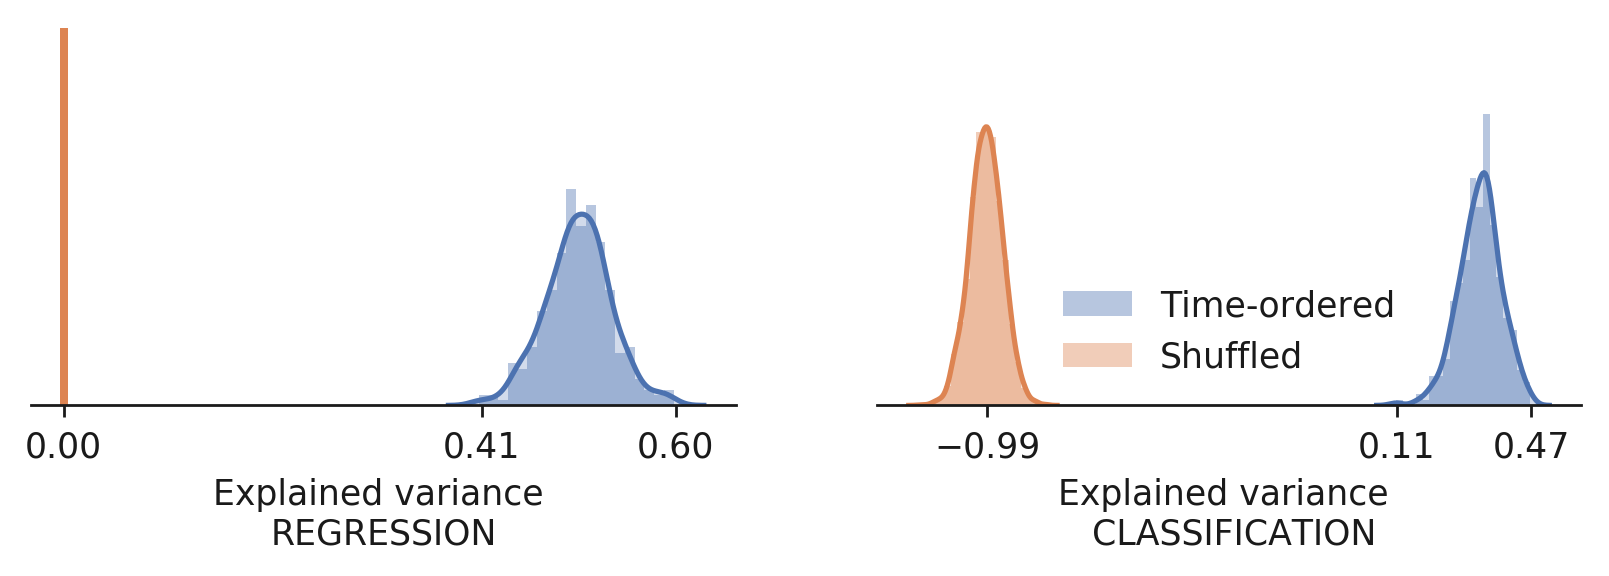

In [41]:
fig, ax = plt.subplots(1,2,figsize=(8,2), dpi=250)
datat = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='Bayesian Ridge') &
                         (full_metric_table.boot==False)].value
sns.distplot(datat, 20, kde_kws=dict(shade=True), ax=ax[0], label='Time-ordered', norm_hist=True)

datab = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='Bayesian Ridge') &
                         (full_metric_table.boot==True)].value
sns.distplot(datab, 20, kde_kws=dict(shade=True), ax=ax[0], label='Shuffled', norm_hist=True)
print(ttest_ind(datat, datab))

ax[0].set_ylim(0,25)
ax[0].set_xticks([0, datat.min().round(2),  datat.max().round(2)])
ax[0].set_yticks([])
ax[0].set_xlabel('Explained variance \nREGRESSION')

datat = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='LDA') &
                         (full_metric_table.boot==False)].value
sns.distplot(datat, 20, kde_kws=dict(shade=True), ax=ax[1], label='Time-ordered', norm_hist=True)

datab = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='LDA') &
                         (full_metric_table.boot==True)].value
sns.distplot(datab, 20, kde_kws=dict(shade=True), ax=ax[1], label='Shuffled', norm_hist=True)
print(ttest_ind(datat, datab))

ax[1].legend(frameon=False)
ax[1].set_ylim(0,12)
ax[1].set_xticks([datab.mean().round(2), datat.min().round(2),  datat.max().round(2)])
ax[1].set_xlabel("Explained variance \n CLASSIFICATION")
ax[1].set_yticks([])

# ax[0].text(0.01, 10, 'Shuffled', color=sns.color_palette('deep')[1])
# ax[0].text(0.45, 15, 'Time-ordered', color=sns.color_palette('deep')[0])

sns.despine(left=True)

In [42]:
ttest_ind(datat, datab)

Ttest_indResult(statistic=486.1298569511709, pvalue=0.0)

In [43]:
ttest_ind(datat, datab)

Ttest_indResult(statistic=486.1298569511709, pvalue=0.0)

### Regression visualization

AttributeError: module 'seaborn' has no attribute 'lineplot'

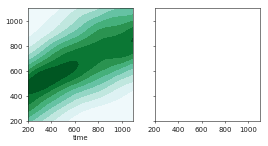

In [47]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=50, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100], vertical=False, bw='scott')
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()

#### SHAP visualization

In [53]:
from sklearn.pipeline import make_pipeline

In [54]:
pipe = make_pipeline(RobustScaler(), Ca())

In [55]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('bayesianridge', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))])

In [60]:
pd.Series(pipe.named_steps.bayesianridge.coef_).abs().sort_values()

125      0.018993
106      0.076881
96       0.131654
99       0.408484
108      0.444195
92       0.445446
18       0.478769
121      0.526820
3        0.614808
95       0.673552
109      0.724586
8        0.755920
21       0.801115
103      0.912525
110      1.163093
105      1.211661
130      1.301319
113      1.389294
82       1.413923
111      1.549375
91       1.598602
128      1.669372
72       1.817755
114      1.845048
16       2.264935
66       2.287511
38       2.375580
124      2.424742
101      2.599743
132      2.634109
          ...    
70      22.770779
89      22.779199
53      22.796253
85      24.396110
48      24.422572
1       24.871317
58      25.497016
14      25.817734
54      26.117992
41      26.831889
73      28.556195
46      29.368792
11      29.656348
88      32.000016
81      32.464966
7       32.488989
68      35.834637
29      35.860263
47      39.504390
31      47.924949
80      48.696128
37      49.830765
59      52.476477
23      54.940418
63      56

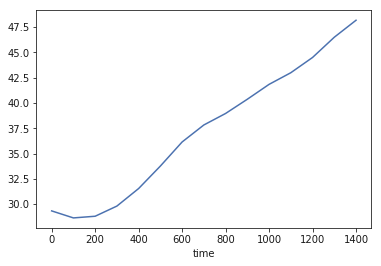

In [66]:
merged.iloc[:,52].unstack().mean().plot()

##### Testing with full subset

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 42s, sys: 1min 20s, total: 3min 3s
Wall time: 17.9 s


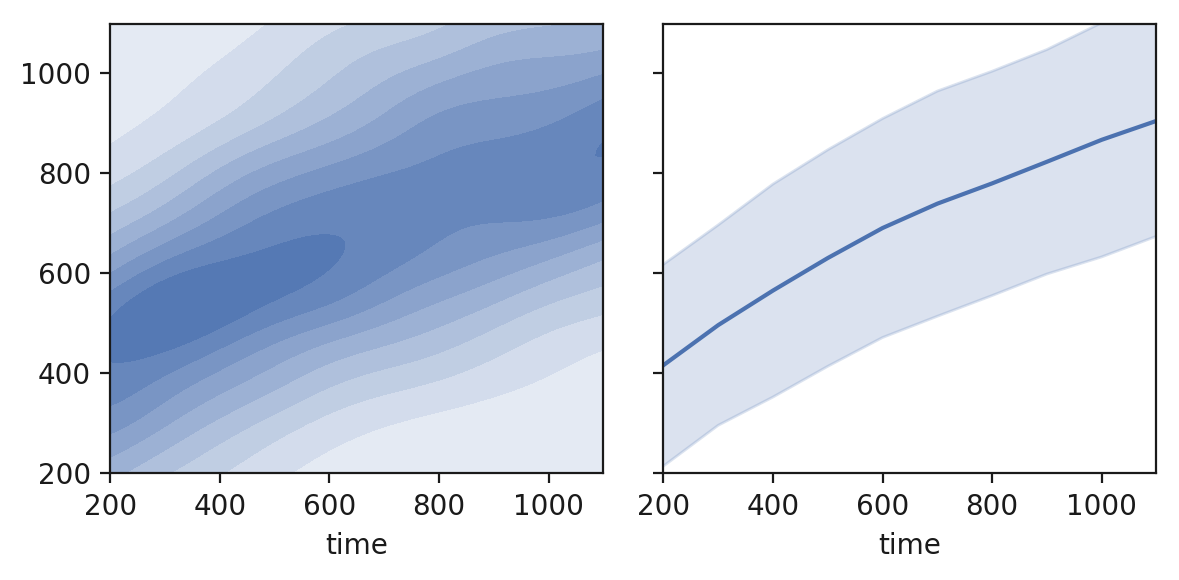

In [45]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 1s, sys: 49.4 s, total: 1min 50s
Wall time: 9.32 s


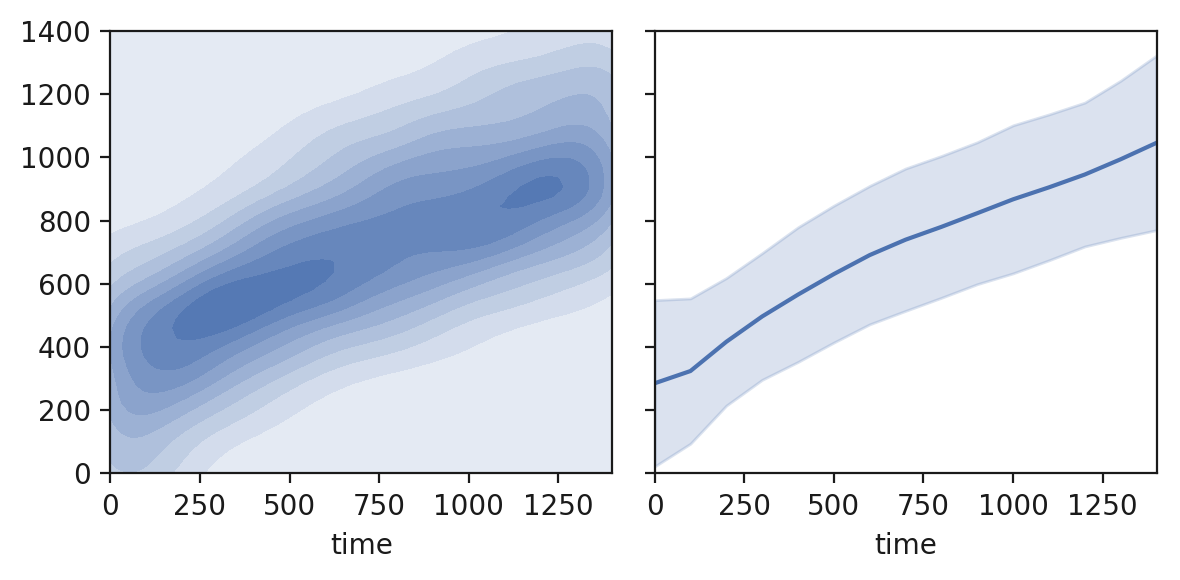

In [46]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0])#, clip=[0,1400])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([0,1400])
plt.xlim([0,1400])

plt.tight_layout()
# plt.suptitle('Regression results')

### Classification visualization

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 36s, sys: 56.5 s, total: 2min 33s
Wall time: 18.3 s


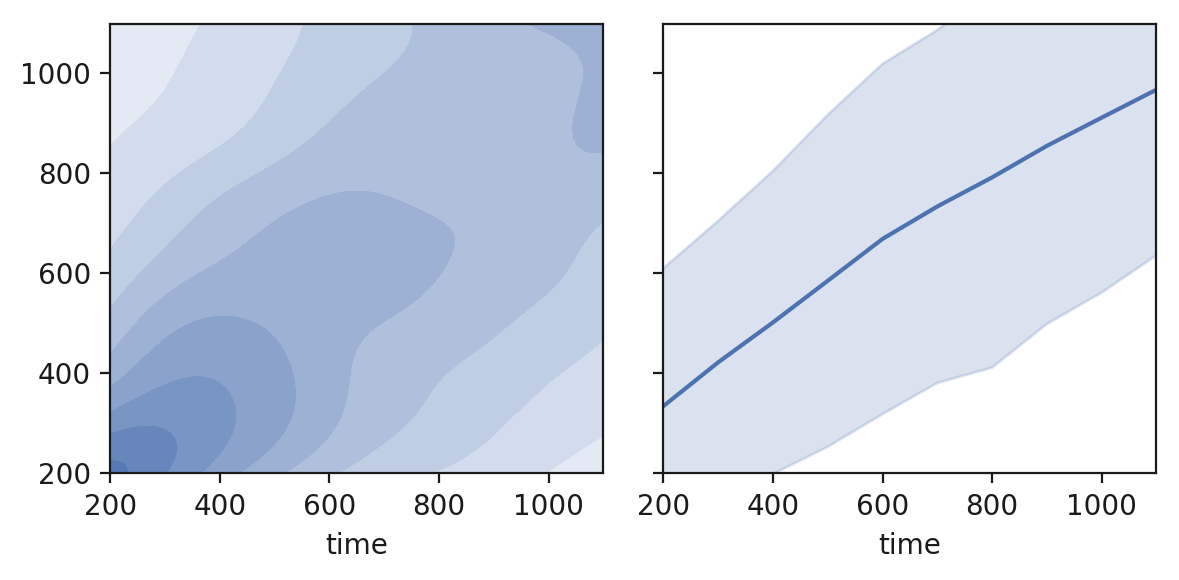

In [47]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = LinearDiscriminantAnalysis()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 27s, sys: 1min 9s, total: 2min 36s
Wall time: 17 s


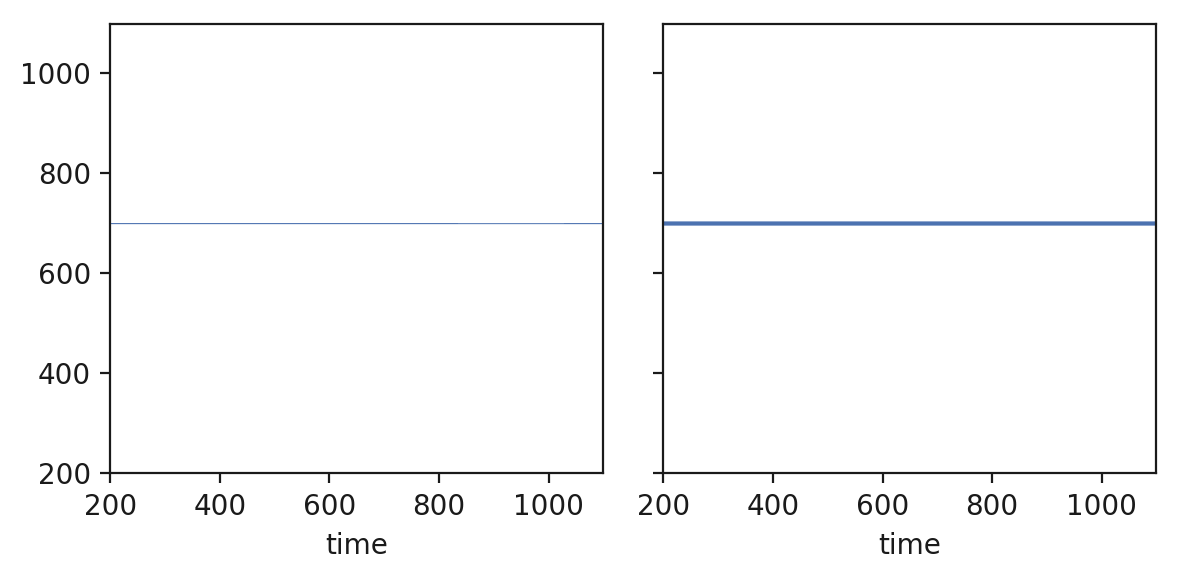

In [48]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 39s, sys: 54.8 s, total: 2min 34s
Wall time: 19.1 s


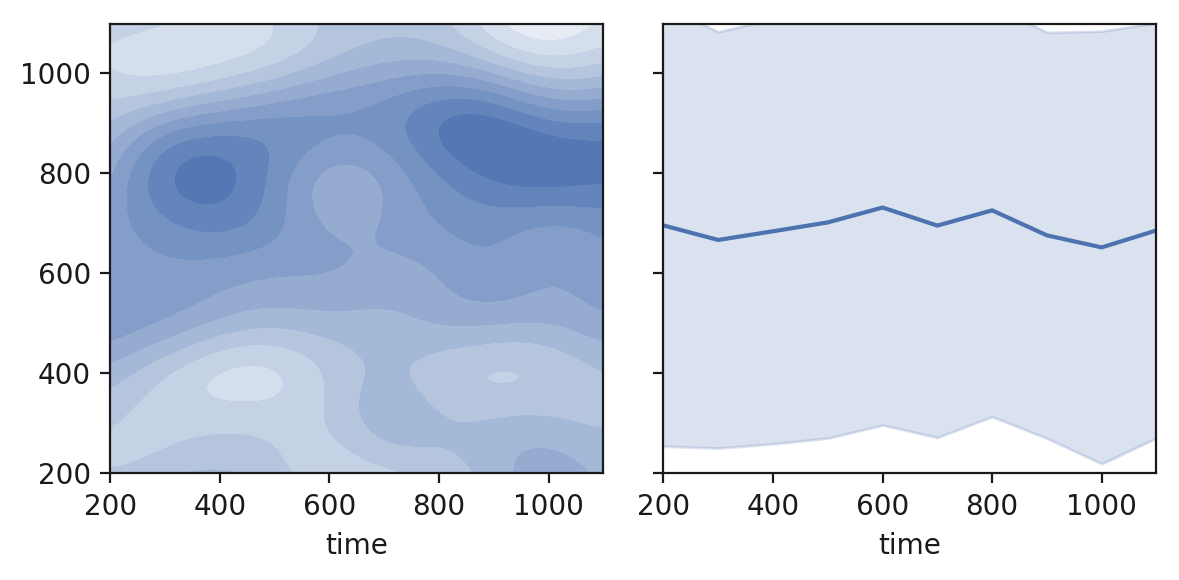

In [49]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = LinearDiscriminantAnalysis()

# Bad rat
boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

### All together 

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 6min 37s, sys: 4min 37s, total: 11min 14s
Wall time: 1min 15s


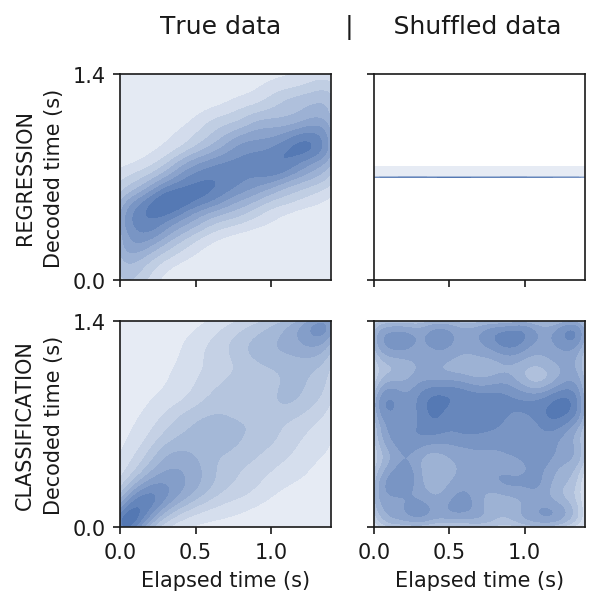

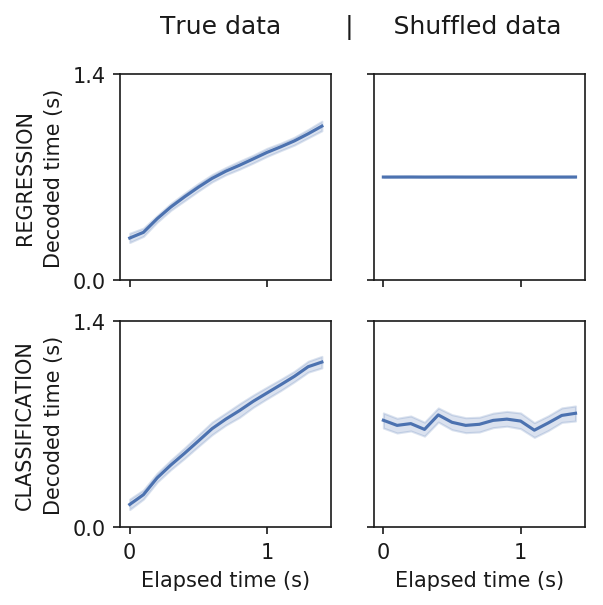

In [50]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                               enumerate([False, True])):

    if boot:
        boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j])
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([0., 1.4])
    ax_[1,0].set_yticks([0., 1.4])

ax2[0,0].set_ylim([0,1.4])
# plt.xlim([200,1100])


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 3min 1s, sys: 2min 6s, total: 5min 7s
Wall time: 35.3 s


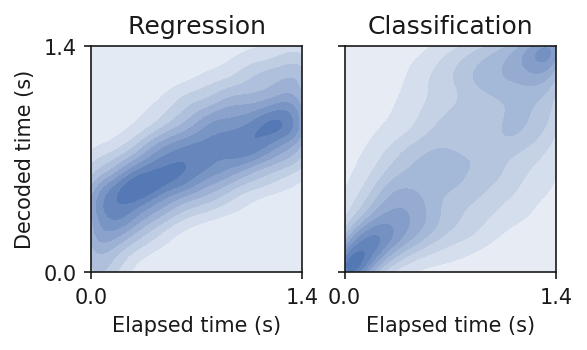

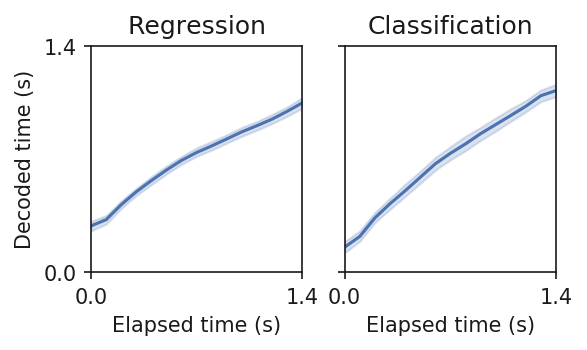

In [51]:
%%time
fig, ax = plt.subplots(1,2, figsize=(4,2), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(1,2, figsize=(4,2), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()

boot = False
i = 0
for (j, clf) in enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]):

    if boot:
        boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[j])
    
# fig.suptitle('    Regression        |     Classification')
# fig2.suptitle('    Regression        |     Classification')


for ax_ in [ax, ax2]:

    ax_[0].set_xlabel('Elapsed time (s)')
    ax_[1].set_xlabel('Elapsed time (s)')

    ax_[0].set_ylabel('Decoded time (s)')
    ax_[1].set_ylabel('')

    ax_[0].set_yticks([0., 1.4])
    
    ax_[0].set_xticks([0., 1.4])
    ax_[1].set_xticks([0., 1.4])

    ax_[0].set_title('Regression')
    ax_[1].set_title('Classification')

    ax_[0].set_xlim([0,1.4])

ax2[0].set_ylim([0,1.4])

# plt.xlim([200,1100])


## There is time-warping consistent with timing behavior

# Representation changes with learning

## Frankenstein

### Data loading

In [52]:
day_1_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' not in l]
dfs_day1 = [nontired_load(label, 'wide_smoothed') for label in day_1_labels]
pfc_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'PFC', subset='full')
str_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'STR', subset='full')

day_2_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' in l]
dfs_day2 = [nontired_load(label, 'wide_smoothed') for label in day_2_labels]
pfc_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'PFC', subset='full')
str_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'STR', subset='full')

543 543
436 287
509 500
936 761
625 625
381 380
437 437
699 699


In [53]:
drec = {}
drec[('PFC', 1)] = pfc_day1
drec[('PFC', 2)] = pfc_day2
drec[('STR', 1)] = str_day1
drec[('STR', 2)] = str_day2

In [54]:
n_features_pfc = min(pfc_day2.shape[1], pfc_day1.shape[1])
n_features_str = min(str_day2.shape[1], str_day1.shape[1])
print('Minimum of neuron in Striatum: ', n_features_str)
print('Minimum of neuron in Pre Frontal Cortex: ', n_features_pfc)
n_features = min(n_features_str, n_features_pfc)
print('Number of features to use: ', n_features)

feat_undersampler = MonteCarloFeatures(n_features)
pipe = make_pipeline(feat_undersampler, RobustScaler(), BayesianRidge())

Minimum of neuron in Striatum:  55
Minimum of neuron in Pre Frontal Cortex:  46
Number of features to use:  46


### Metric calculations

In [55]:
# merged = frankenstein(dfs, _min_duration=1.5, is_tired=False, is_selected=True)
size = merged.shape[0]

half1 = merged[:size//2]
half2 = merged[size//2:]

res1 = cross_val(half1, pipe)
res2 = cross_val(half2, pipe)

print(res1.groupby('variable').mean())
print(res2.groupby('variable').mean())

                       value
variable                    
Accuracy            0.104437
Explained variance  0.361306
Pearson's r         0.603657
                       value
variable                    
Accuracy            0.093517
Explained variance  0.269551
Pearson's r         0.525046


In [56]:
res1['Session stage'] = 'Beginning'
res2['Session stage'] = 'Ending'
pres = pd.concat([res1,res2])

In [57]:
res = pd.DataFrame()
for df, name in zip([pfc_day1, str_day1, pfc_day2, str_day2], 
                    ['pfc_day1','str_day1','pfc_day2','str_day2']):
    print(df.shape)
    %time local = cross_val(df, pipe, 1000)
    local['area'] = name[:3]
    local['day'] = name[-1]
    res = res.append(local)

(1755, 46)
CPU times: user 41min 4s, sys: 46min 1s, total: 1h 27min 5s
Wall time: 4min 23s
(1755, 55)
CPU times: user 42min 42s, sys: 48min 24s, total: 1h 31min 6s
Wall time: 4min 29s
(3045, 50)
CPU times: user 44min 58s, sys: 50min 30s, total: 1h 35min 29s
Wall time: 5min 2s
(3045, 60)
CPU times: user 46min 14s, sys: 51min 18s, total: 1h 37min 32s
Wall time: 5min 11s


In [58]:
res['area'] = res['area'].apply(lambda s: 'Pre Frontal Cortex' if s=='pfc' else 'Striatum')

#### Visualization

##### Pearson

In [59]:
sns.set_palette('deep')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


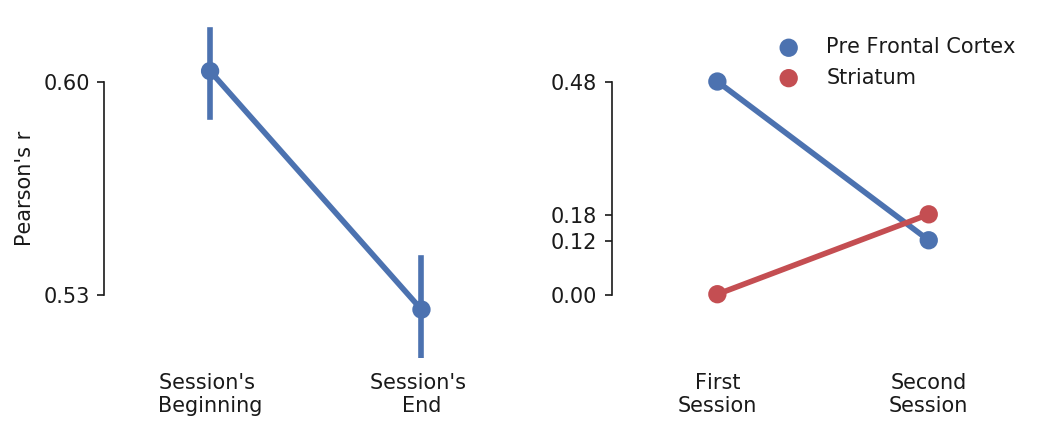

In [60]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


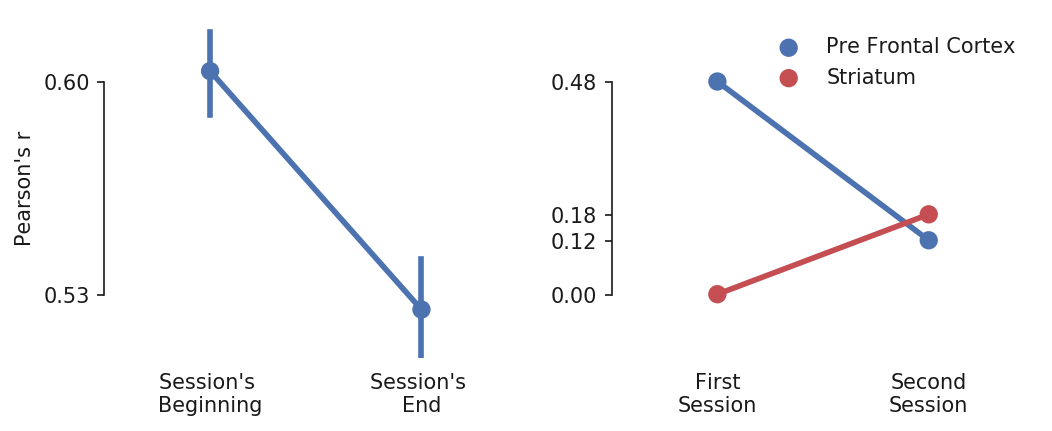

In [61]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


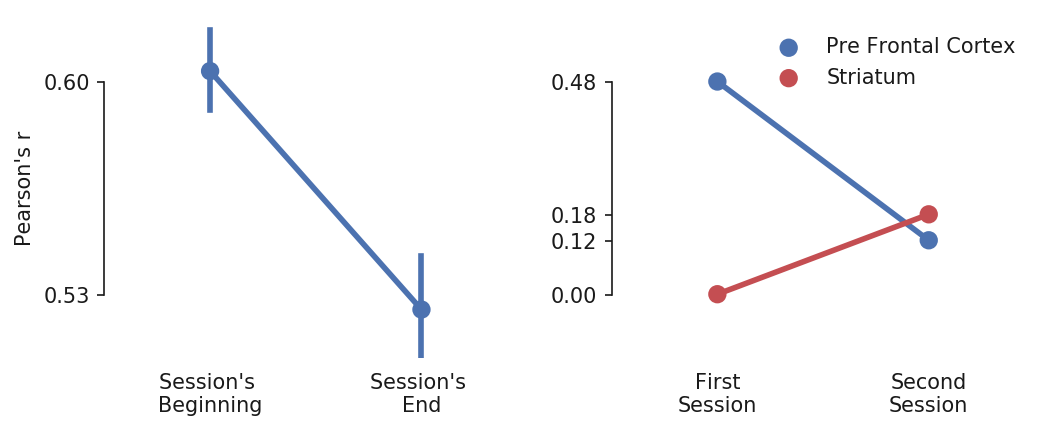

In [62]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [63]:
t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])


P-value for PFC half vs half: 			 8.320254480494902e-11
P-value for PFC session 1 vs session 2: 	 0.0
P-value for Striatum session 1 vs session 2: 	 0.0
t-value for PFC half vs half: 			 6.865896239469334
t-value for PFC session 1 vs session 2: 	 118.68369369156898
t-value for Striatum session 1 vs session 2: 	 -47.41915390444001


##### Explained variance 

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


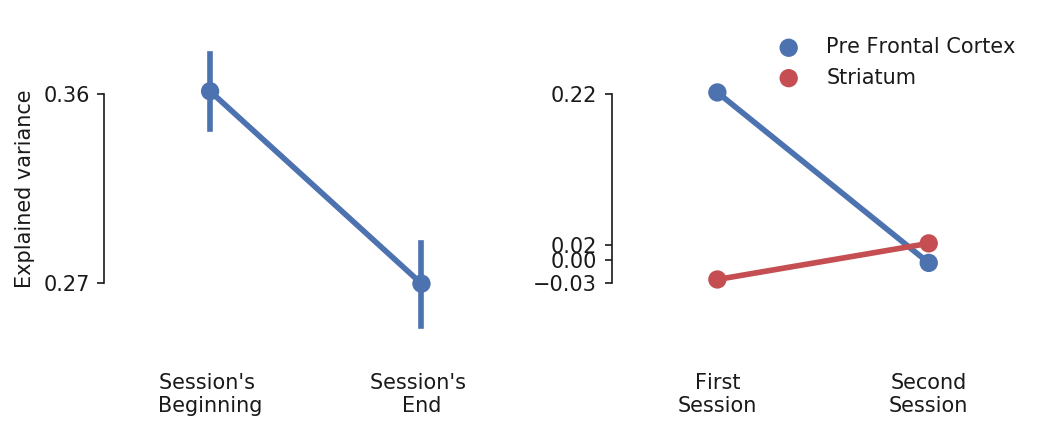

In [64]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


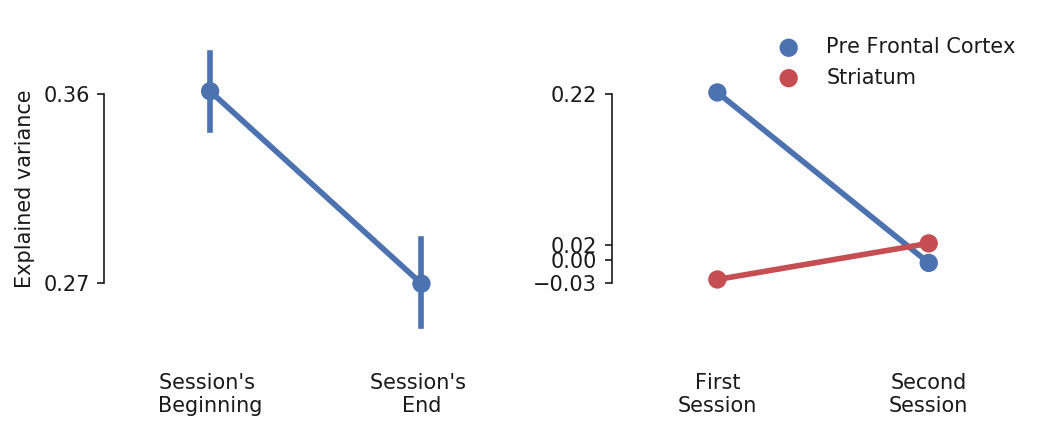

In [65]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [66]:
t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 1.386898778622581e-10
P-value for PFC session 1 vs session 2: 	 0.0
P-value for Striatum session 1 vs session 2: 	 2.3738106379269835e-126
t-value for PFC half vs half: 			 6.77523526096566
t-value for PFC session 1 vs session 2: 	 89.38919774410368
t-value for Striatum session 1 vs session 2: 	 -25.731220554453074


##### Accuracy

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


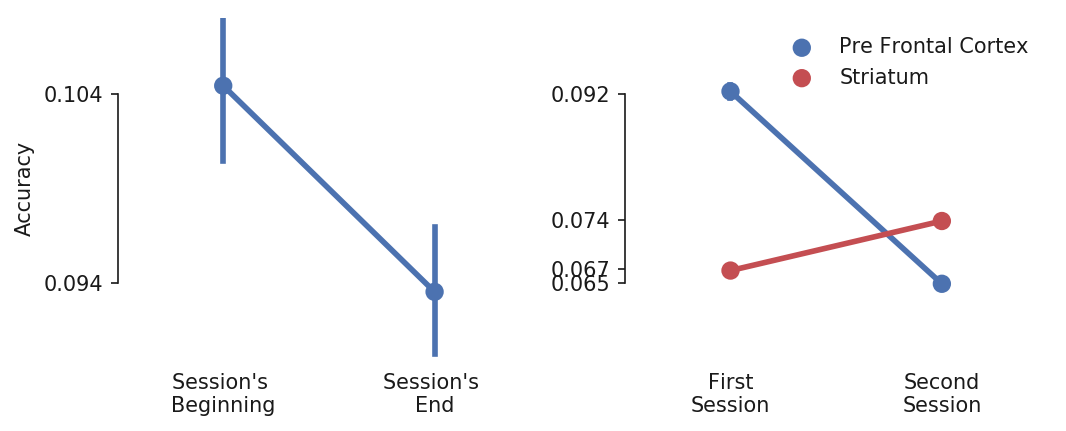

In [67]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


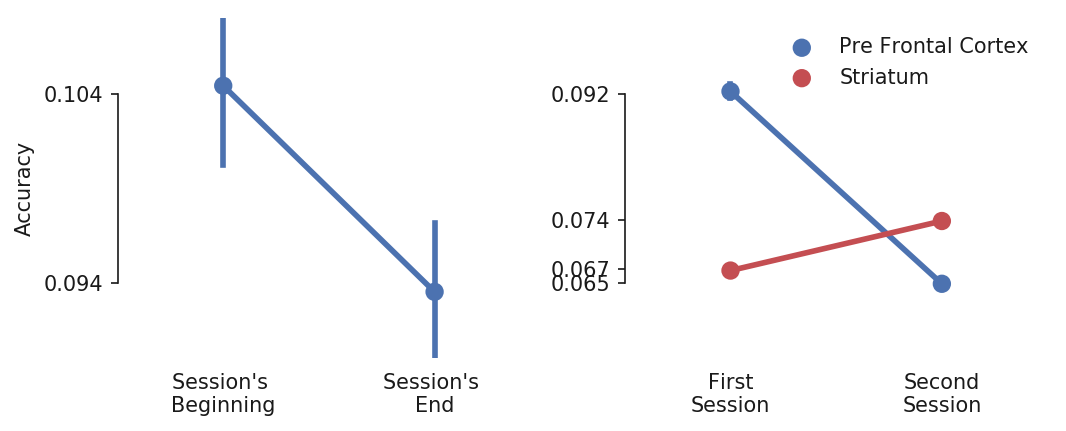

In [68]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [69]:
t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 5.7099305384998786e-05
P-value for PFC session 1 vs session 2: 	 0.0
P-value for Striatum session 1 vs session 2: 	 5.4572520408892146e-74
t-value for PFC half vs half: 			 4.113578597501015
t-value for PFC session 1 vs session 2: 	 49.16475148049483
t-value for Striatum session 1 vs session 2: 	 -18.980116659444835


## One-day striatum

### Data loading

In [234]:
day_1_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' not in l]
dfs_day1 = [nontired_load(label, 'wide_smoothed') for label in day_1_labels]

543 543
436 287
509 500
936 761


In [235]:
day_1_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' not in l]
dfs_day1 = [nontired_load(label, 'wide_smoothed') for label in day_1_labels]

merged_pfc = frankenstein(dfs_day1, _min_duration=1.5, area = 'PFC', subset='full')
merged_str = frankenstein(dfs_day1, _min_duration=1.5, area = 'STR', subset='full')

pfc_day1 = merged_pfc.iloc[:merged_pfc.shape[0]//2]
str_day1 = merged_str.iloc[:merged_str.shape[0]//2]

pfc_day2 = merged_pfc.iloc[merged_pfc.shape[0]//2:]
str_day2 = merged_str.iloc[merged_str.shape[0]//2:]

543 543
436 287
509 500
936 761


In [72]:
drec = {}
drec[('PFC', 1)] = pfc_day1
drec[('PFC', 2)] = pfc_day2
drec[('STR', 1)] = str_day1
drec[('STR', 2)] = str_day2

In [73]:
n_features_pfc = min(pfc_day2.shape[1], pfc_day1.shape[1])
n_features_str = min(str_day2.shape[1], str_day1.shape[1])
print('Minimum of neuron in Striatum: ', n_features_str)
print('Minimum of neuron in Pre Frontal Cortex: ', n_features_pfc)
n_features = min(n_features_str, n_features_pfc)
print('Number of features to use: ', n_features)

feat_undersampler = MonteCarloFeatures(n_features)
pipe = make_pipeline(feat_undersampler, RobustScaler(), BayesianRidge())

Minimum of neuron in Striatum:  55
Minimum of neuron in Pre Frontal Cortex:  46
Number of features to use:  46


### Metric calculations

In [74]:
res = pd.DataFrame()
for df, name in zip([pfc_day1, str_day1, pfc_day2, str_day2], 
                    ['pfc_half_1','str_half_1','pfc_half_2','str_half_2']):
    print(df.shape)
    %time local = cross_val(df, pipe, 1000)
    local['area'] = name[:3]
    local['day'] = name[-1]
    res = res.append(local)

(877, 46)
CPU times: user 35min 16s, sys: 36min 47s, total: 1h 12min 4s
Wall time: 3min 33s
(877, 55)
CPU times: user 37min 6s, sys: 42min 17s, total: 1h 19min 23s
Wall time: 4min 6s
(878, 46)
CPU times: user 33min 14s, sys: 35min 40s, total: 1h 8min 54s
Wall time: 3min 32s
(878, 55)
CPU times: user 37min 25s, sys: 42min 1s, total: 1h 19min 27s
Wall time: 4min 8s


In [75]:
res['area'] = res['area'].apply(lambda s: 'Pre Frontal Cortex' if s=='pfc' else 'Striatum')

#### Visualization

##### Pearson

In [76]:
sns.set_palette('deep')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


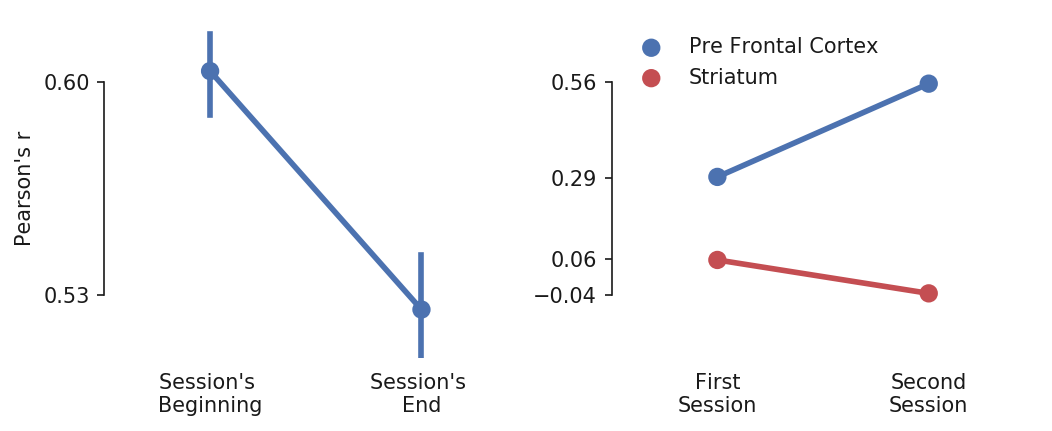

In [77]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [78]:
t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])


P-value for PFC half vs half: 			 8.320254480494902e-11
P-value for PFC session 1 vs session 2: 	 0.0
P-value for Striatum session 1 vs session 2: 	 6.820815732638827e-53
t-value for PFC half vs half: 			 6.865896239469334
t-value for PFC session 1 vs session 2: 	 -47.53942825965152
t-value for Striatum session 1 vs session 2: 	 15.769457667900749


##### Explained variance 

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


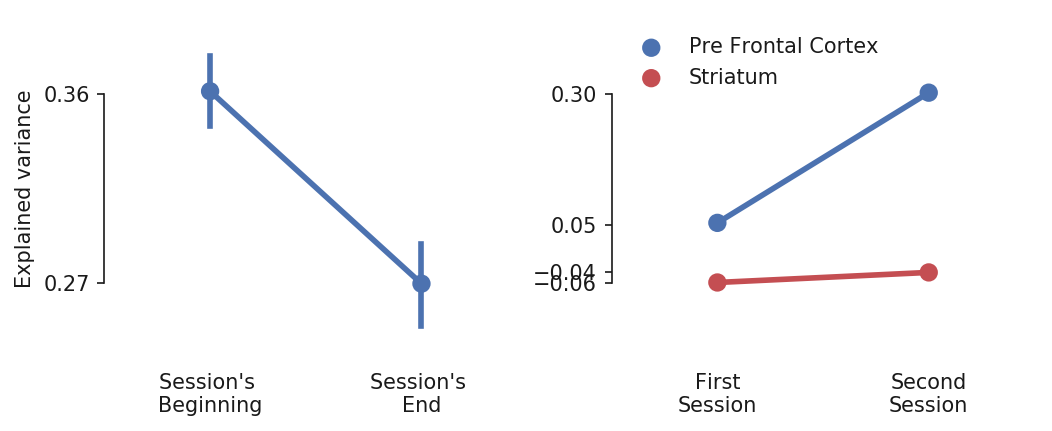

In [79]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


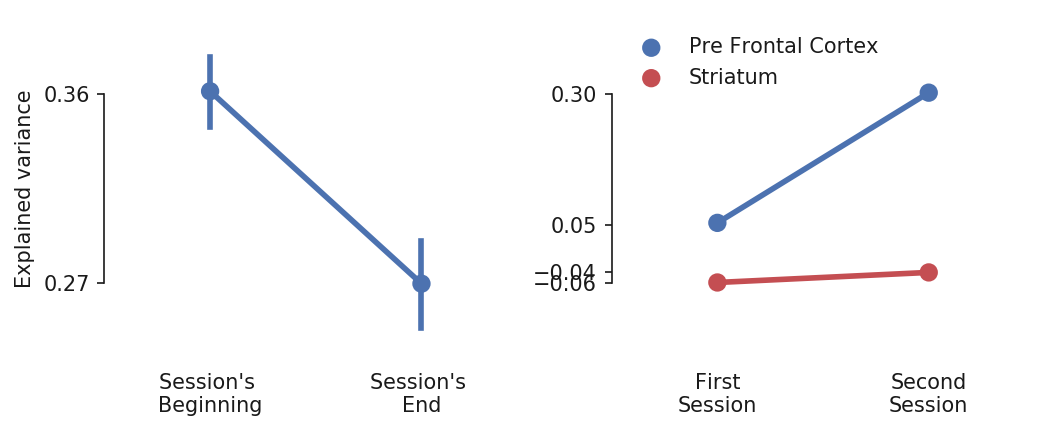

In [80]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [81]:
t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 1.386898778622581e-10
P-value for PFC session 1 vs session 2: 	 0.0
P-value for Striatum session 1 vs session 2: 	 2.9053152446886574e-07
t-value for PFC half vs half: 			 6.77523526096566
t-value for PFC session 1 vs session 2: 	 -50.676952021765814
t-value for Striatum session 1 vs session 2: 	 -5.14706934272363


##### Accuracy

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


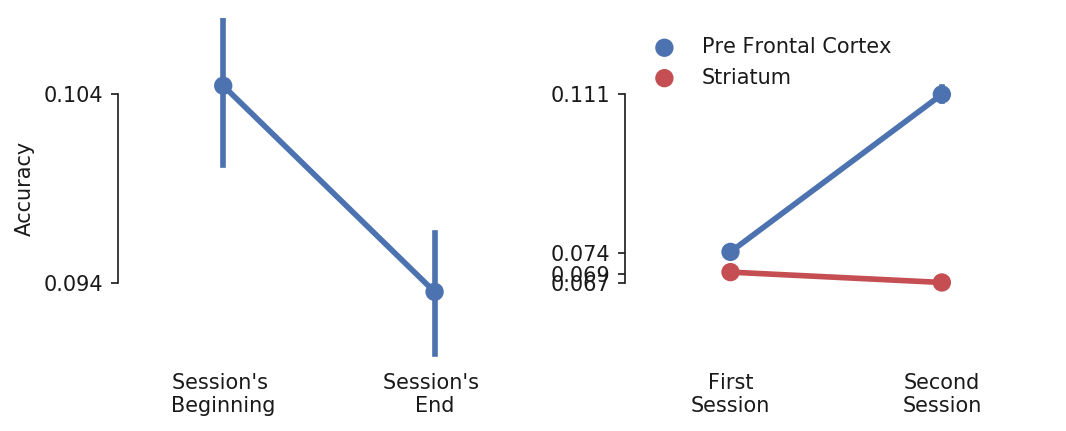

In [82]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


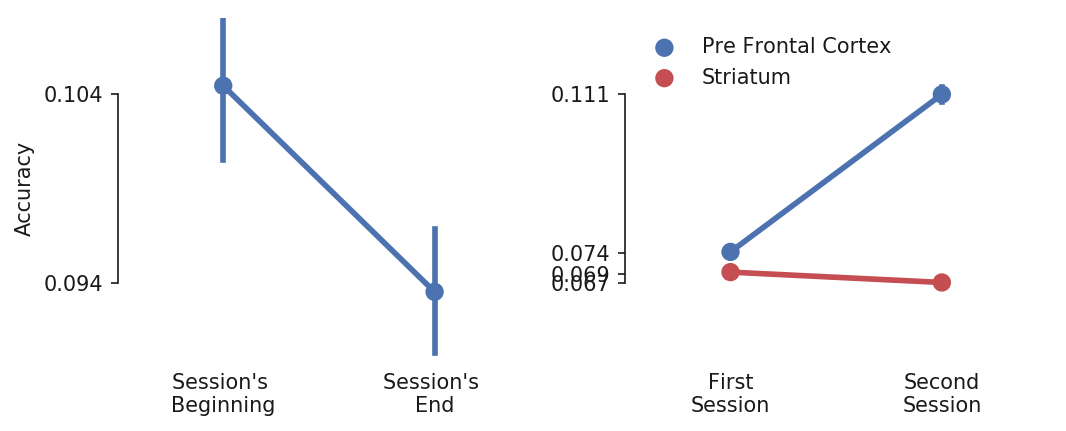

In [83]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [84]:
t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 5.7099305384998786e-05
P-value for PFC session 1 vs session 2: 	 1.1654670673543072e-215
P-value for Striatum session 1 vs session 2: 	 1.3819791733003383e-05
t-value for PFC half vs half: 			 4.113578597501015
t-value for PFC session 1 vs session 2: 	 -35.6283059014932
t-value for Striatum session 1 vs session 2: 	 4.357548602510914


## Prediction visualizations

### Striatum

#### Day 1 

In [85]:
str_shuf = str_day1.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 2min 25s, sys: 1min 56s, total: 4min 21s
Wall time: 25.3 s


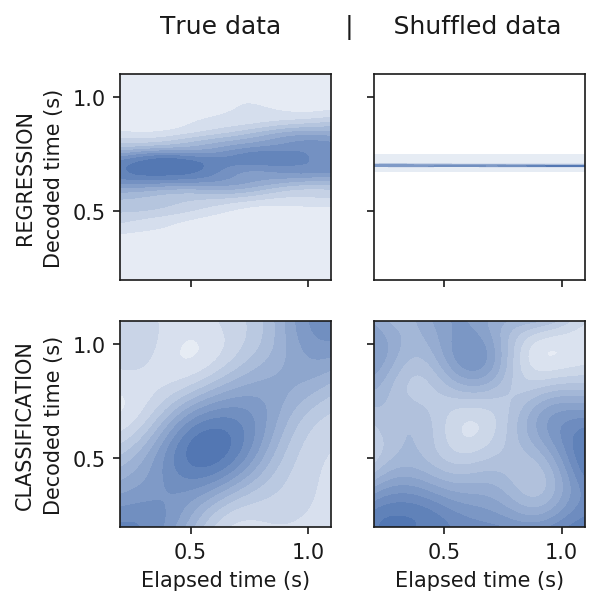

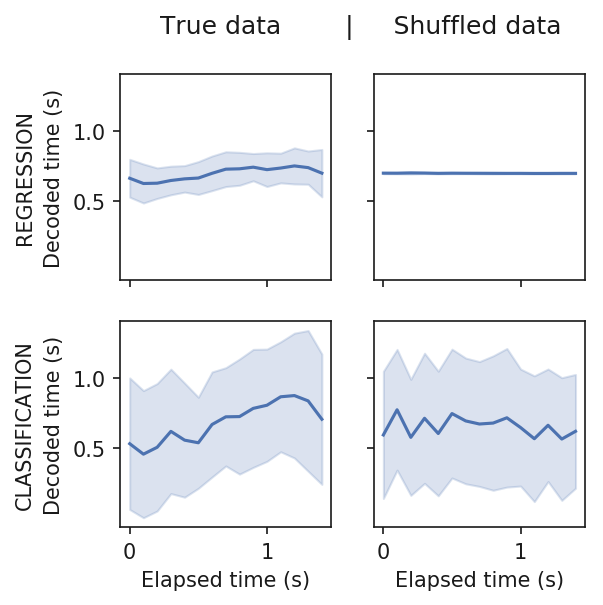

In [86]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)

    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


#### Day 2

In [87]:
str_shuf = str_day2.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 2min 32s, sys: 1min 56s, total: 4min 29s
Wall time: 27.6 s


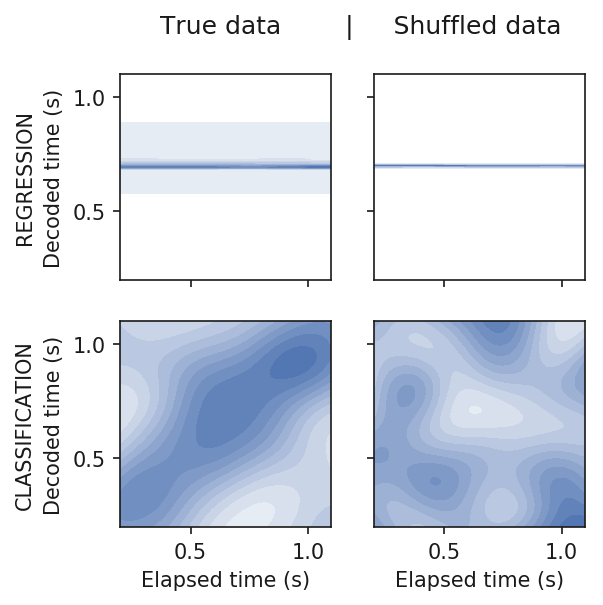

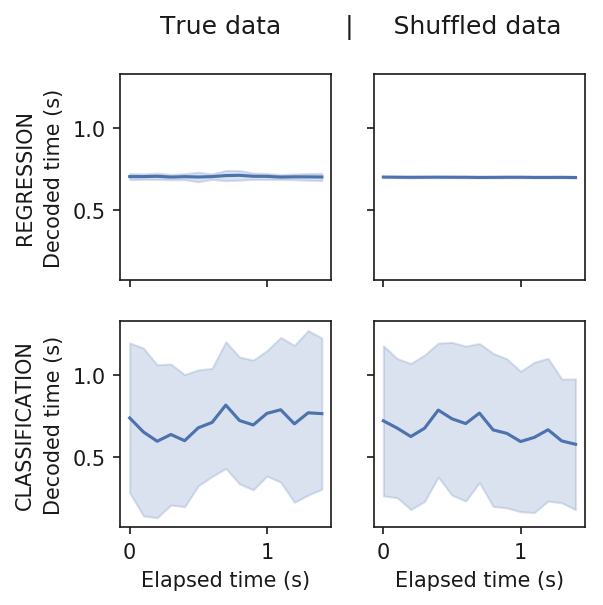

In [88]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    
    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


### Pre Frontal Cortex

#### Day 1 

In [89]:
str_shuf = pfc_day1.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 2min 30s, sys: 1min 54s, total: 4min 24s
Wall time: 25.9 s


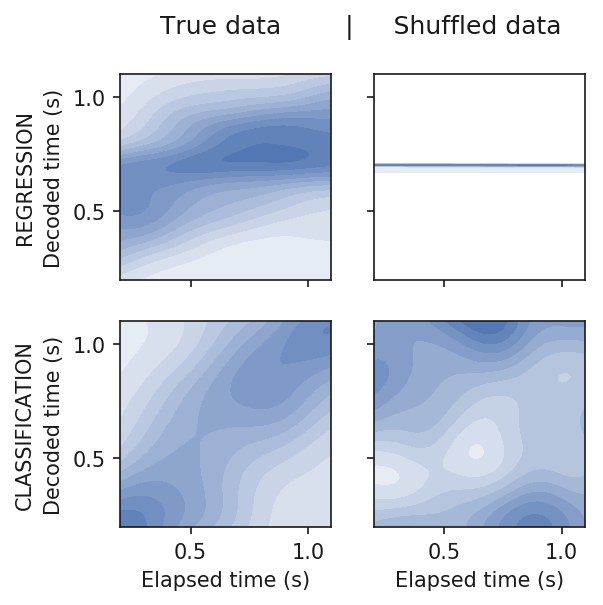

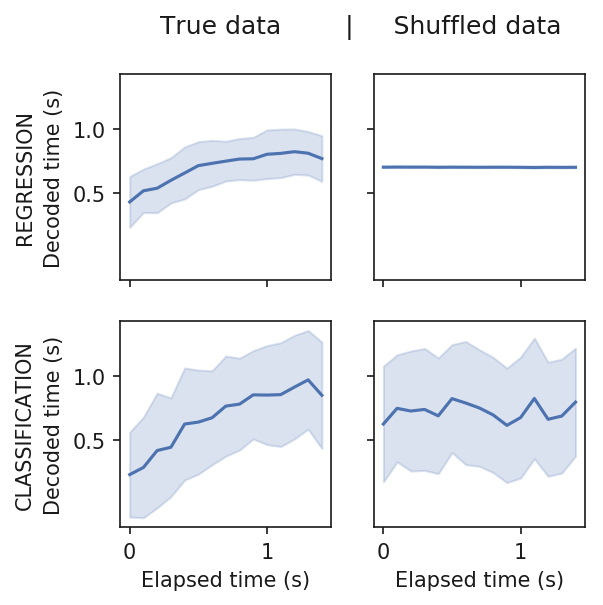

In [90]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)

    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


#### Day 2

In [91]:
str_shuf = pfc_day2.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 2min 28s, sys: 2min 4s, total: 4min 33s
Wall time: 26.4 s


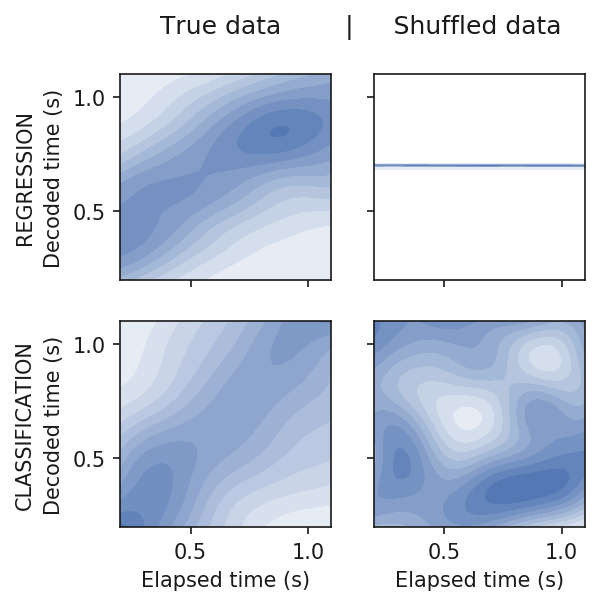

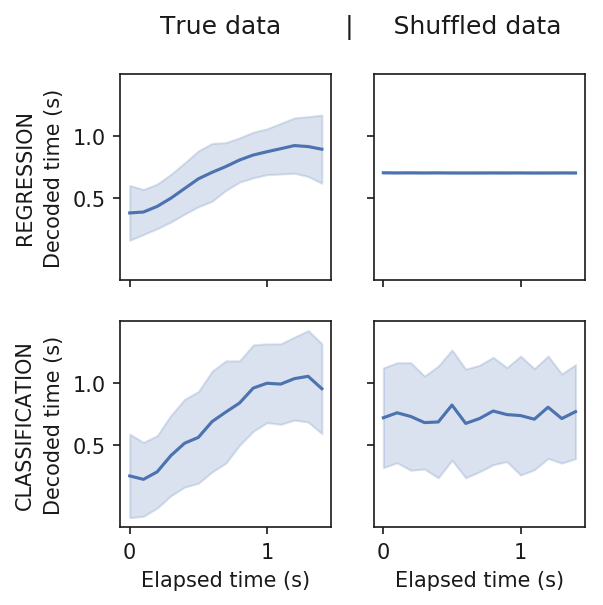

In [92]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    
    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


### All together

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 3min 27s, sys: 3min 44s, total: 7min 11s
Wall time: 36.7 s


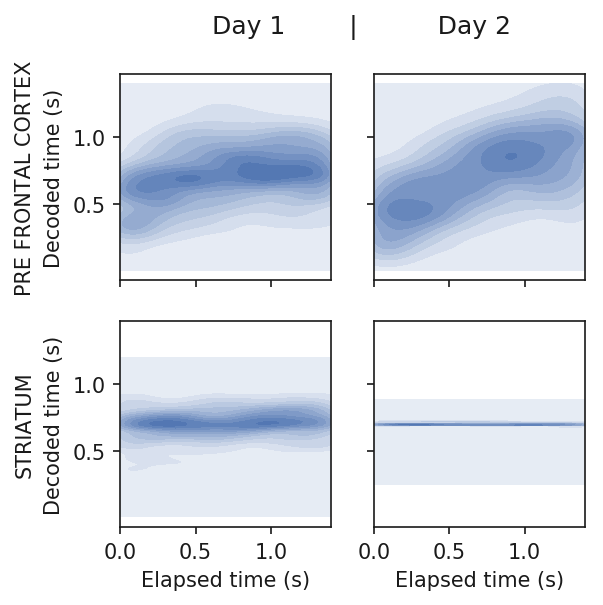

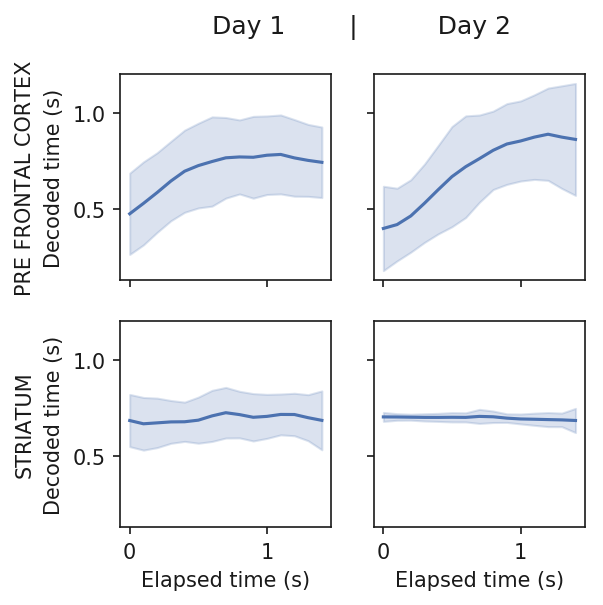

In [93]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()
for (i, area), (j, day) in product(enumerate(['PFC', 'STR']),
                                  enumerate([1, 2])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    df = drec[(area, day)]

    X,y, trial = df.values, df.reset_index().time, df.reset_index().trial
    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    Day 1        |          Day 2')
fig2.suptitle('    Day 1        |          Day 2')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'PRE FRONTAL CORTEX', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'STRIATUM', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


# Visualizations

## Matrix

In [111]:
dft = pfc_day1.iloc[::5,:5].round(1)

In [115]:
dft.columns = pd.Index(['Neuron 1', 'Neuron 2', 'Neuron 3', 'Neuron 4', 'Neuron 5'], name='Firing rate')

In [116]:
dft

Firing rate   Neuron 1  Neuron 2  Neuron 3  Neuron 4  Neuron 5
trial time                                                    
0.0   0.0          1.0       0.4       1.4       0.1       0.0
      500.0        0.0       1.9       1.2       1.5       0.5
      1000.0       0.0       0.0       0.0       8.2       1.1
1.0   0.0          5.1       0.4       0.6       1.5       0.2
      500.0        0.0       1.0       0.7       4.6       2.5
      1000.0       0.0      13.7       5.4       0.3       7.6
2.0   0.0          0.4       0.0      13.3       3.1       2.0
      500.0        0.0       0.0       1.0       3.2       0.0
      1000.0       0.0       0.0       1.1       0.0       0.0
3.0   0.0          0.0      12.6       0.0       0.0       0.2
      500.0        0.0       9.4       0.0       0.0       0.5
      1000.0       2.5       5.4       0.0       1.2       7.3
4.0   0.0          3.8       9.1       4.1       7.6       6.3
      500.0        5.4       0.0       0.2       3.0       0.0
      1000.0       0.1       0.0       9.1       4.5      14.6
5.0   0.0          0.0       8.7       3.9       0.0       0.8
      500.0        0.0       6.8       0.0       0.0       3.0
      1000.0       3.3       4.2      11.2       7.8       2.8
6.0   0.0          3.8       0.0       6.6       0.3       2.6
      500.0        0.0       0.0       3.0       0.2       0.1
      1000.0       1.9       2.7       0.0       0.0       0.6
7.0   0.0          1.8       3.3       0.0       8.6       0.1
      500.0        1.6       0.8       3.7       9.8       4.8
      1000.0       0.0       2.4      23.0       4.7       2.9
8.0   0.0          0.5       0.0       2.8      19.1       0.0
      500.0        0.0       3.1       4.1       6.3       0.8
      1000.0       4.2       0.0       1.0       8.4       3.7
9.0   0.0          3.8       0.0       1.8       0.3       1.3
      500.0        5.2       6.3       0.0      15.4       3.7
      1000.0       1.1       0.1       0.0       4.7       0.0
...                ...       ...       ...       ...       ...
48.0  1000.0       0.1       0.0       3.6       0.4       1.6
49.0  0.0          0.0       0.0      11.5       0.1       0.0
      500.0        3.7       3.8      11.2       3.9       0.0
      1000.0       0.0       2.2       1.3       3.0       0.0
50.0  0.0          7.1       1.0      12.3       0.0      10.4
      500.0        0.0       3.8       0.4       3.8       3.6
      1000.0       6.5       0.0       1.4      14.1       0.9
51.0  0.0          5.1       0.0       3.4       0.0       4.2
      500.0        0.0       3.2       2.0       6.0       0.0
      1000.0       6.0       4.0       0.0      11.3       0.0
52.0  0.0          0.0       3.0       0.0       0.8       0.3
      500.0        0.0       3.1       1.4       3.1       9.0
      1000.0       0.0       0.0       0.0       0.0       6.9
53.0  0.0          3.8       1.7       0.0       3.7       5.2
      500.0        0.0       4.4       4.0       0.6       5.8
      1000.0       4.1       0.2       5.3       0.8       0.1
54.0  0.0          0.1       0.0       0.3       0.0       0.7
      500.0        0.5       0.0       0.0       5.3       1.0
      1000.0       3.9       0.0       0.0       4.4       6.2
55.0  0.0          0.0       0.0       0.0       0.0       0.0
      500.0        5.5       0.0       0.0       1.1       0.1
      1000.0       3.6       0.0       0.0       4.2       4.5
56.0  0.0          3.1       3.1       3.6       3.8       7.6
      500.0        2.5       0.1      21.9       2.3       3.8
      1000.0       0.2       0.0       0.3       9.9       3.1
57.0  0.0          2.3       0.0       4.8       0.1       3.8
      500.0        4.8       6.1       0.1       7.1       4.5
      1000.0      12.4       5.1       0.0       0.0       3.6
58.0  0.0          3.6       0.0       3.7       0.9       0.3
      500.0        8.2       4.8       0.0       1.4       0.6

[176 rows x 5 columns]

## Monte Carlo crossval

In [172]:
r = np.random.rand(60, 20)
train = (r<.7)
test = (r>.7) & (r<.9)
out = r>.9

In [191]:
import matplotlib.lines as mlines

blue_star = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                          markersize=10, label='Blue stars')


In [207]:
import matplotlib.cm as cm

In [216]:
cm.prism(1)

(1.0, 0.0, 0.0, 1.0)

Text(-0.8,-2,'Monte carlo cross validation')

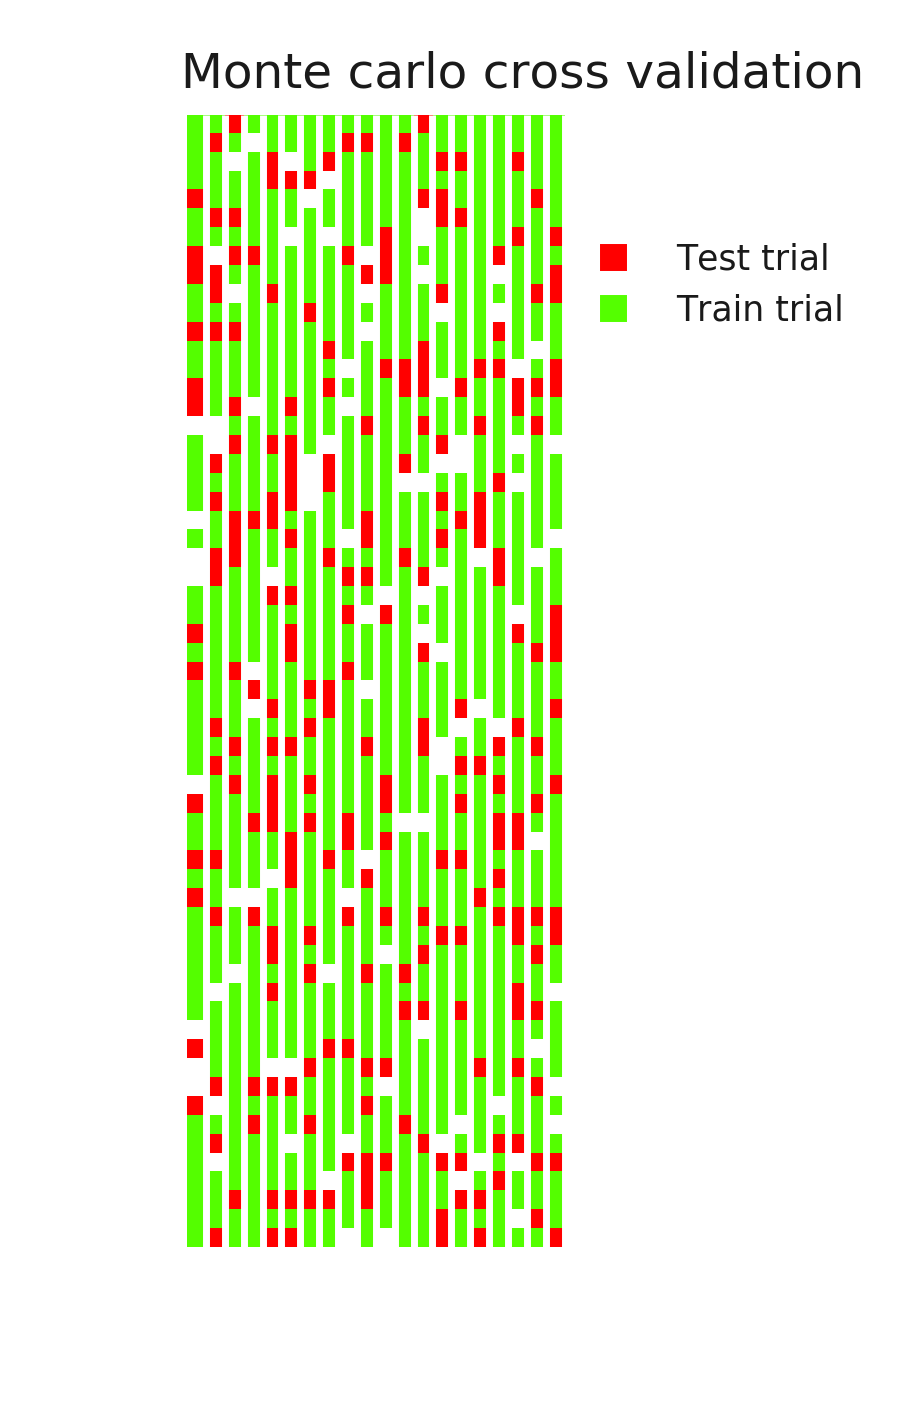

In [221]:
plt.figure(figsize=(6,3), dpi=500)
red_square = mlines.Line2D([], [], color=cm.prism(0), marker='s', linestyle='None',
                          markersize=3, label='Test trial')
green_square = mlines.Line2D([], [], color=cm.prism(256), marker='s', linestyle='None',
                          markersize=3, label='Train trial')

plt.imshow(np.ma.masked_where(out, train), cmap='prism')
plt.gca().set_axis_off()
plt.vlines(np.arange(20)+.5, -.5, 59.5, linewidth=1, color='w')
plt.legend(handles=[red_square, green_square], loc=(1,.8), fontsize=5, frameon=False)
plt.text(-.8,-2, 'Monte carlo cross validation', fontsize=7)

# Each rat striatum

## One-day striatum

### Data loading

In [222]:
day_1_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' not in l]
dfs_day1 = [nontired_load(label, 'wide_smoothed') for label in day_1_labels]

543 543
436 287
509 500
936 761


In [284]:
pfc_dfs = [to_feature_array(select(df, _min_duration=1.5, area = 'PFC'), subset='cropped') for df in dfs_day1]
str_dfs = [to_feature_array(select(df, _min_duration=1.5, area = 'STR'), subset='cropped') for df in dfs_day1]

In [285]:
[df.shape for df in pfc_dfs]

[(2780, 4), (1170, 33), (1550, 5), (3050, 4)]

In [286]:
[df.shape for df in str_dfs]

[(2780, 12), (1170, 26), (1550, 16), (3050, 1)]

In [287]:
str_dfs = str_dfs[:-1]

In [288]:
[df.shape for df in str_dfs]

[(2780, 12), (1170, 26), (1550, 16)]

### Remove baseline

In [289]:
str_dfs = [df.drop([-500, -400, -300, -200, -100], level=1) for df in str_dfs]
pfc_dfs = [df.drop([-500, -400, -300, -200, -100], level=1) for df in pfc_dfs]

In [290]:
[df.shape for df in pfc_dfs]

[(2780, 4), (1170, 33), (1550, 5), (3050, 4)]

In [291]:
feat_undersampler = MonteCarloFeatures(4)
pipe = make_pipeline(feat_undersampler, RobustScaler(), BayesianRidge())

### PFC 

In [292]:
res = pd.DataFrame()
for df, name in zip(pfc_dfs, [1,2,3,4]):
    print(df.shape)
    
    %time local = cross_val(df.iloc[:df.shape[0]//2], pipe, 1000)
    local['rat'] = name
    local['area'] = 'pfc'
    local['moment'] = 'beginning'
    res = res.append(local)
    
    %time local = cross_val(df.iloc[df.shape[0]//2:], pipe, 1000)
    local['rat'] = name
    local['area'] = 'pfc'
    local['moment'] = 'end'
    
    res = res.append(local)

(2780, 4)
CPU times: user 10.3 s, sys: 26.3 ms, total: 10.4 s
Wall time: 10.4 s
CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s
(1170, 33)
CPU times: user 9.33 s, sys: 0 ns, total: 9.33 s
Wall time: 9.33 s
CPU times: user 9.47 s, sys: 0 ns, total: 9.47 s
Wall time: 9.47 s
(1550, 5)
CPU times: user 9.1 s, sys: 0 ns, total: 9.1 s
Wall time: 9.1 s
CPU times: user 9.13 s, sys: 0 ns, total: 9.13 s
Wall time: 9.13 s
(3050, 4)
CPU times: user 8.96 s, sys: 0 ns, total: 8.96 s
Wall time: 8.95 s
CPU times: user 9.39 s, sys: 0 ns, total: 9.39 s
Wall time: 9.39 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


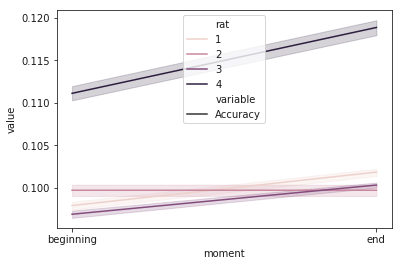

In [293]:
sns.lineplot(data=res[res.variable=='Accuracy'], x='moment', hue='rat', style='variable', y='value')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


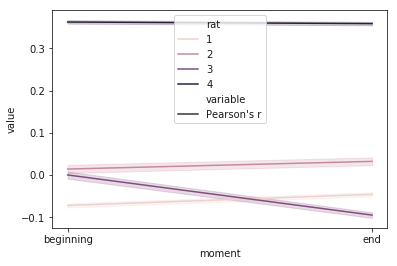

In [294]:
sns.lineplot(data=res[res.variable=="Pearson's r"], x='moment', hue='rat', style='variable', y='value')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


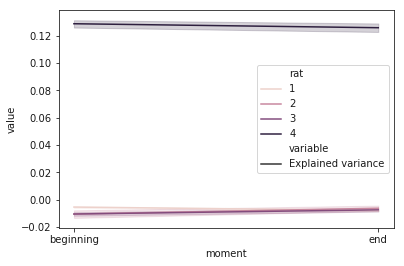

In [295]:
sns.lineplot(data=res[res.variable=='Explained variance'], x='moment', hue='rat', style='variable', y='value')

In [296]:
res.groupby([ 'variable', 'rat', 'moment']).mean().loc["Pearson's r"].unstack()

value          
moment beginning       end
rat                       
1      -0.071788 -0.045491
2       0.014443  0.032625
3       0.000454 -0.094580
4       0.362639  0.358877

# Striatum

In [297]:
[df.shape for df in str_dfs]

[(2780, 12), (1170, 26), (1550, 16)]

In [298]:
feat_undersampler = MonteCarloFeatures(12)
pipe = make_pipeline(feat_undersampler, RobustScaler(), BayesianRidge())

In [299]:
res = pd.DataFrame()
for df, name in zip(str_dfs, [1,2,3]):
    print(df.shape)
    
    %time local = cross_val(df.iloc[:df.shape[0]//2], pipe, 1000)
    local['rat'] = name
    local['area'] = 'pfc'
    local['moment'] = 'beginning'
    res = res.append(local)
    
    %time local = cross_val(df.iloc[df.shape[0]//2:], pipe, 1000)
    local['rat'] = name
    local['area'] = 'pfc'
    local['moment'] = 'end'
    
    res = res.append(local)

(2780, 12)
CPU times: user 12min 11s, sys: 10min 43s, total: 22min 54s
Wall time: 34.5 s
CPU times: user 11min 34s, sys: 9min 58s, total: 21min 33s
Wall time: 32.4 s
(1170, 26)
CPU times: user 4min 3s, sys: 20.7 s, total: 4min 23s
Wall time: 13.1 s
CPU times: user 3min 53s, sys: 19.1 s, total: 4min 12s
Wall time: 12.6 s
(1550, 16)
CPU times: user 3min 50s, sys: 18.9 s, total: 4min 9s
Wall time: 12.5 s
CPU times: user 3min 51s, sys: 18.9 s, total: 4min 10s
Wall time: 12.5 s


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


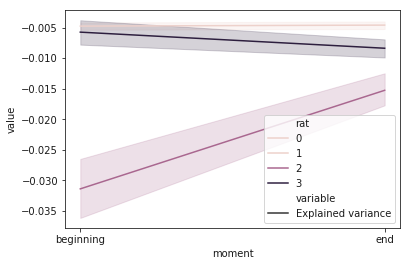

In [300]:
sns.lineplot(data=res[res.variable=="Explained variance"], x='moment', hue='rat', style='variable', y='value')

In [301]:
res.groupby([ 'variable', 'rat', 'moment']).mean().loc["Pearson's r"].unstack()

value          
moment beginning       end
rat                       
1      -0.009443 -0.006220
2       0.010477 -0.006917
3       0.066931 -0.053803